In [1]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.tensor_module

In [53]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import os
import pickle
import modules.dataset_auxiliary as daux
from modules.dataset_auxiliary import *
from modules.classification_auxiliary import *
from modules.ml_auxiliary import *
from modules.tensor_module import *
import copy

# Tensors
import tntorch as tn
import tensorly as tl
from tensorly import random
from tensorly.decomposition import tucker, parafac, partial_tucker
from tensorly.tenalg import mode_dot, multi_mode_dot


# ML
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

import xgboost as xgb
import pystmm


In [3]:
ls

backup/       model_results.ipynb  requirements.txt   tensors.ipynb
bullets/      modules/             script_work.ipynb  tensors_my.ipynb
env/          out.txt              stages/            tensors_online.ipynb
gestures.txt  readme.md            Tasks.txt


## Load initial ds_dict

In [4]:
# current version
file_path = r'backup/ds_dict.pkl'

# # save:
# with open(file_path, 'wb') as f:
#     pickle.dump(ds_dict, f)

# load:
with open(file_path, 'rb') as f:
    ds_dict = pickle.load(f)

check_ds_dict(ds_dict)
print()

True 	Info: 7468;   Skeleton: 7468;   Total: 7468



In [5]:
ds_dict['G101__trial1__left__call']['info']['label']

{'is_valid_performance': True, 'action_start': 18.0, 'action_end': 61.0}

## Selecting 

In [6]:
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']
# gestures += ['scroll_up', 'scroll_down', 'swipe_right', 'swipe_left', 'export'] 
# gestures += ['screenshot', 'writing', 'delete']
# gestures += ['moving_down', 'moving_left', 'moving_right', 'moving_up', 'moving_back', 'moving_forward']
# gestures += ['anticlockwise', 'clockwise', 'right_forward', 'left_forward']
# gestures += ['zoom_in_c', 'zoom_out_c', 'zoom_out_l', 'zoom_out_r', 'zoom_in_l',  'zoom_in_r']
# gestures += ['yes_head', 'no_head']

In [7]:
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[0:16], test: subs[16:]"
exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
# exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"

Selected  2812 samples. 4656(7468) was dropped!
14 samples was unvalied. Ramain 2798(2812)


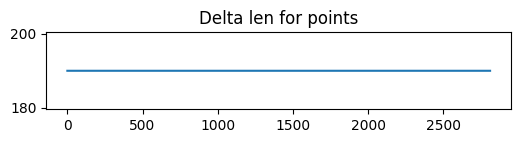

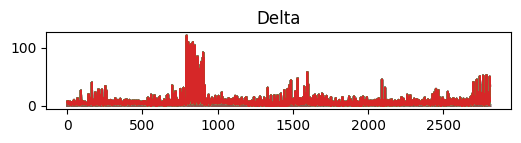

Train
Selected  2152 samples. 660(2812) was dropped!
Test
Selected  660 samples. 2152(2812) was dropped!


In [8]:
# preparing

subs = get_all_subs_from_ds_dict(ds_dict)
subs = subs[:]
# gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']


data_dict_selected = select_g_ids(ds_dict, subs=subs, gestures=gestures)
data_dict_valid =  select_valid_samplels(data_dict_selected)

# points
data_dict_points = select_points(data_dict_selected, coords=['x', 'y'])
plt.show()

# nan
data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'value':0})
plt.show()

data_dict_adjusted = update_skeleton(data_dict_filled, update_df_solve_time, show=False)


#train
print('Train')
data_dict = select_g_ids(data_dict_adjusted, subs=subs[5:])
data_dict, label_dict = form_gesture_labels(data_dict)
samples_list,  labels_list = form_samples_labels_lists(data_dict)
data_tensor = np.concatenate(samples_list, axis=0)

#test 
print('Test')
data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[:5])
data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
data_tensor_test = np.concatenate(samples_list_test, axis=0)



## Tensor preprocessing

### CPD

In [249]:
# CPD - Bad!!
t = data_tensor
tt = data_tensor_test
rank = 8
factors_CPD = parafac(t, rank=rank)


In [336]:
t_rec_CPD = tl.cp_to_tensor(factors_CPD)
print(f"CPD: Rank: {rank: }, distance: {tl.norm(t - t_rec_CPD)} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_CPD)}")

ValueError: too many values to unpack (expected 2)

In [308]:

factors = factors_CPD
# core = gen_diag_core_tensor(rank,len(factors.factors), factors.weights)
# tensor = mode_dot(core_t, factors.factors[0], mode=0)

tensor_CPD = multi_mode_dot(t, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])
tensor_CPD_test = multi_mode_dot(tt, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])

### SVD

In [10]:
matrix_SVD, matrix_SVD_test = get_SVD_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2)

Decomposition with rank: 5688. tensor shape: (5688, 120, 134)
SVD: Rank: 5688, rel_error:  0.00000 ; norm origin: 5982.350322460426 ; norm recovered: 5982.350322460426


In [12]:
matrix_SVD.shape

(5688, 5688)

#### code

In [22]:
t = data_tensor
tt = data_tensor_test

t_uf0 = tl.unfold(t, mode=0)
tt_uf0 = tl.unfold(tt, mode=0)

u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
norm_t = tl.norm(t)

rank = 600
# rank = 5688



In [51]:
rank = 600

In [52]:
t_rec_SVD = recover_svd((u_0, s_0, v_0), rank=rank)
print(f"SVD: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec_SVD)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec_SVD)}")

SVD: Rank: 600, rel_error:  0.00587 ; norm origin: 5982.350322460426 ; norm recovered: 5982.24737107641


In [54]:
matrix_SVD = np.matmul(t_uf0, v_0[:rank, :].T)
matrix_SVD_test = np.matmul(tt_uf0, v_0[:rank, :].T)

In [9]:
def get_SVD_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2):
    t = data_tensor
    tt = data_tensor_test

    t_uf0 = tl.unfold(t, mode=0)
    tt_uf0 = tl.unfold(tt, mode=0)
    
    u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
    
    if rank is None or rank == -1:
        rank = len(s_0)
        
    if verbose > 1:
        print(f"Decomposition with rank: {rank}. tensor shape: {data_tensor.shape}")

    if verbose > 0:
        norm_t = tl.norm(t)
        t_rec_SVD = recover_svd((u_0, s_0, v_0), rank=rank)
        print(f"SVD: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec_SVD)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec_SVD)}")
            
        matrix_SVD = np.matmul(t_uf0, v_0[:rank, :].T)
        matrix_SVD_test = np.matmul(tt_uf0, v_0[:rank, :].T)
    return matrix_SVD, matrix_SVD_test

#### Selecting rank

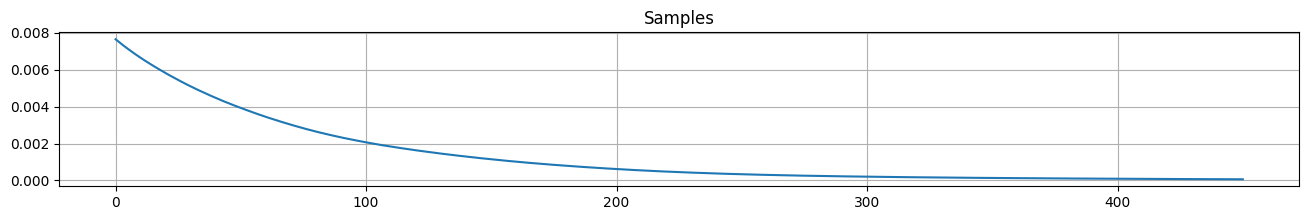

In [28]:
show_decomposition_error(s_0, norm_t,'Samples',show=False, start=50, end=500)
# plt.gcf().set_size_inches((16, 2))

### Tucker

In [60]:
# tensor_tucker, tensor_tucker_test = get_tucker_tensors(data_tensor, data_tensor_test)

Tucker decomposition with rank: (120, 134). tensor shape: (2152, 120, 134)
Tucker: Rank: (120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903


In [59]:
tensor_tucker_, tensor_tucker_test_ = get_tucker_tensors_v2(data_tensor, data_tensor_test)

Tucker decomposition with rank: (2152, 120, 134). tensor shape: (2152, 120, 134)
tensor(4.0316e-06)
Tucker: Rank: (2152, 120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.634765625


In [67]:
# (tensor_tucker_test - tensor_tucker_test_).max()

16.00771727716271

#### test several libs

In [61]:
# # tntorch 
# # get_tucker_tensors_v2(data_tensor, data_tensor_test)
# data = torch.Tensor(data_tensor)
# t2 = tn.Tensor(data, ranks_tucker=[10, 20, 30])

# tn.relative_error(data, t2)

# t2.Us[0].T @ t2.Us[0]
# t2.tucker_core().shape

# t2

#### code

In [26]:
# Tucker with HOSVD
t = data_tensor
tt = data_tensor_test
rank = [120, 134]
core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)

# rank = [8, 60, 20]
# core_tucker, factors_tucker = tucker(t, rank=rank)


In [11]:
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

Tucker: Rank: [120, 134], rel_error:  0.00000 ; norm origin: 5982.350322460424 ; norm recovered: 5982.350322460414


In [140]:
# # t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

In [12]:
# factors = factors_tucker
# factors = [None] + factors

# tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
# tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])

# # core = core_tucker
# # tensor_tucker = mode_dot(core, factors[0], mode=0)

In [8]:
# def get_tucker_tensors(data_tensor, data_tensor_test, rank=None, n_iter_max=1000, verbose=1):
#     t = data_tensor
#     tt = data_tensor_test
    
#     if rank is None:
#         rank = data_tensor.shape[1:]
        
#     modes = [i for i in range(len(data_tensor.shape))]
#     modes = modes[1:]
#     core_tucker, factors_tucker = partial_tucker(t, modes, rank=rank, n_iter_max=n_iter_max)
    
#     if verbose > 0:
#         t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
#         print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")
            
#     factors = factors_tucker
#     factors = [None] + factors
#     tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=modes)
#     tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=modes)
        
#     return tensor_tucker, tensor_tucker_test
        

#### Selecting ranks

In [130]:
t_uf0 = tl.unfold(t, mode=0)
t_uf1 = tl.unfold(t, mode=1)
t_uf2 = tl.unfold(t, mode=2)

In [131]:
# u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
u_1, s_1, v_1 = tl.partial_svd(t_uf1, 120)
u_2, s_2, v_2 = tl.partial_svd(t_uf2, 134)

norm_t = tl.norm(t)

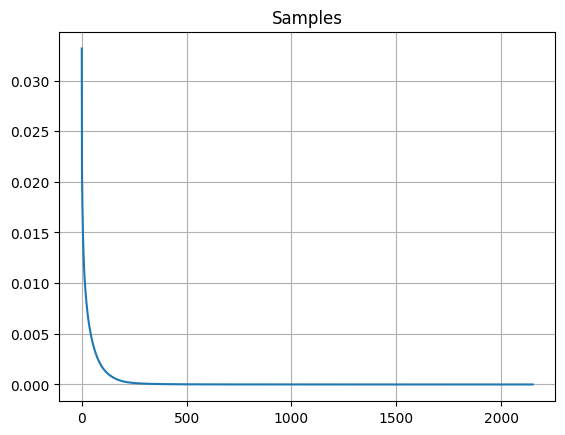

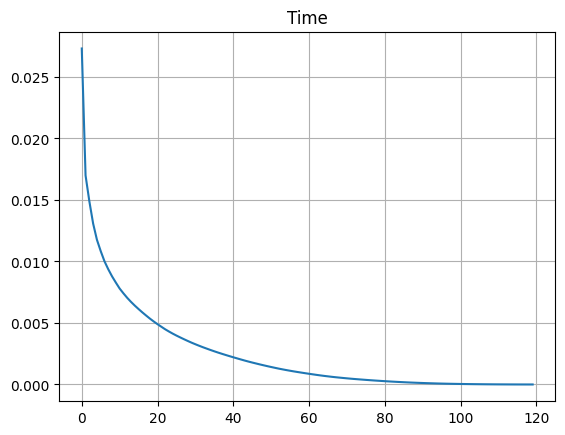

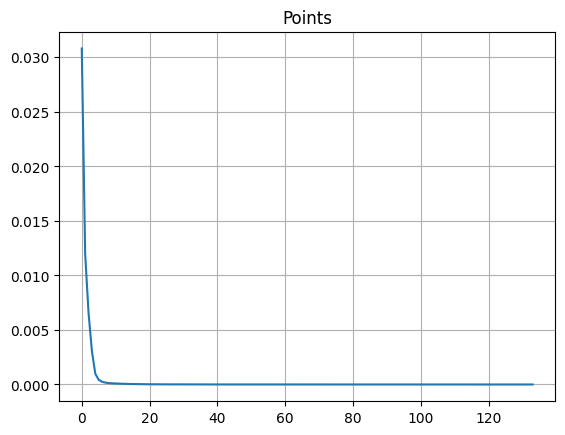

In [157]:
show_decomposition_error(s_0, norm_t,'Samples',)
show_decomposition_error(s_1, norm_t,'Time',)
show_decomposition_error(s_2, norm_t,'Points',)


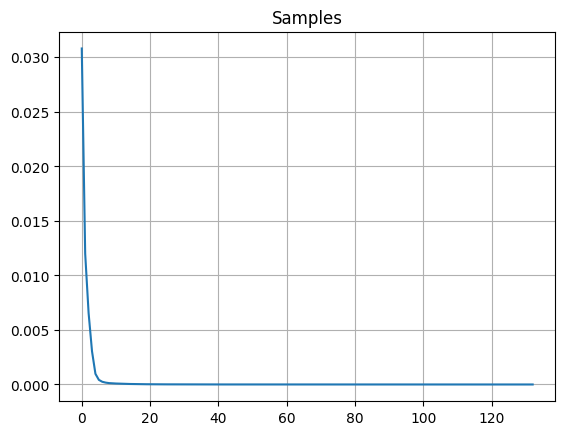

In [134]:
show_decomposition_error(s_2, norm_t,'Samples', d_step=1)

### ML Cross validation 

In [ ]:
def do_cross_validation_per_subs(data_dict_adjusted, model_pair, decompose=None, decompose_rank=-1,  n_trials=10, subs=-1, pref='',  step=5,):
    if subs == -1:
        subs = get_all_subs_from_ds_dict(data_dict_adjusted)
        
    acc_list = []
    for i, cv_block in enumerate(split_cross_validation(data_dict_adjusted, subs, step=step)):
        data_tensor, data_tensor_test, labels_list, labels_list_test = cv_block
        
        
        print(f"Decomposition {decompose} with rank {decompose_rank}:", end='   ')
        if decompose is None:
            decompose = 'none'
            
        decompose = decompose.lower()
            
        if decompose in ['none', '-']:
            tensor = data_tensor
            tensor_test = data_tensor_test
        elif decompose in ['tucker']:
                tensor, tensor_test = get_tucker_tensors(data_tensor, data_tensor_test, rank=decompose_rank, verbose=2)
        elif decompose in ['svd']:
            tensor, tensor_test = get_SVD_tensors(data_tensor, data_tensor_test, rank=decompose_rank, verbose=2)
        # print(" was done!")
            
        decompose_str = '' if decompose in ['none', '-'] else decompose + '+' 
        acc_trial_list = []
        print(f'Start testing model: {decompose_str + model_pair[1]}')
        for j in range(n_trials):
            print('j =', j, ': ', end='')
            acc = test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref=pref, verbose=0)
            print(acc)
            acc_trial_list += [acc]
        acc_trial_array = np.array(acc_trial_list)
        acc_mean = acc_trial_array.mean()
        acc_std = acc_trial_array.std(ddof=1)
        
        acc_list += [acc]
        print(f"Acc[{i}] = {100*acc_mean:2.2f}({100*acc_std:2.2f})%")
        print()
    print()
    acc_array = np.array(acc_list)
    print(f"Cross validation with {i+1} blocks was ended.")
    print(f"Mean acc={100*acc_array.mean():2.2f}%")
    
    return acc_list
    
    
    
    

In [15]:
model_pair = (RandomForestClassifier(n_estimators=1, max_depth=2, n_jobs=-1), 'RandForest')
ass_array = do_cross_validation_per_subs(data_dict_adjusted, model_pair, 'Tucker', pref='', decompose_rank=[8,8], step=7,)


For test subjects: ['G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107']
Selected  4986 samples. 2482(7468) was dropped!
Selected  2482 samples. 4986(7468) was dropped!
Decomposition Tucker with rank [8, 8]:   Decomposition with rank: [8, 8]. tensor shape: (4986, 120, 134)
Tucker: Rank: [8, 8], rel_error:  0.11315 ; norm origin: 5613.683332579163 ; norm recovered: 5577.633769428874
Start testing model: tucker+RandForest
j = 0 : 0.08259468170829976
j = 1 : 0.1031426269137792
j = 2 : 0.09669621273166801
j = 3 : 0.06365834004834811
j = 4 : 0.088638195004029
j = 5 : 0.09830781627719581
j = 6 : 0.0854149879129734
j = 7 : 0.05922643029814666
j = 8 : 0.08259468170829976
j = 9 : 0.0684931506849315
Acc[0] = 8.29(1.50)%


For test subjects: ['G108', 'G109', 'G110', 'G111', 'G112', 'G113', 'G114']
Selected  4960 samples. 2508(7468) was dropped!
Selected  2508 samples. 4960(7468) was dropped!
Decomposition tucker with rank [8, 8]:   Decomposition with rank: [8, 8]. tensor shape: (4960, 120, 13

In [111]:
cv_list = [cv for cv in split_cross_validation(data_dict_adjusted, subs, step=7)]


For test subjects: ['G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107']

For test subjects: ['G108', 'G109', 'G110', 'G111', 'G112', 'G113', 'G114']

For test subjects: ['G115', 'G116', 'G117', 'G118', 'G119', 'G120', 'G121']


In [ ]:


def split_cross_validation(data_dict_adjusted, subs, step=5):
    
    end = len(subs) - step
    if len(subs) % step == 0:
        end +=1
            
    cv_list = []

    for i, start in enumerate([ii for ii in range(0, end, step)]):
        
        test_subs = [sub for sub in subs[start:start+step]]
        train_subs = [sub for sub in subs if sub not in test_subs]
        print(f"\nFor test subjects: {test_subs}")
        
        # train
        data_dict = select_g_ids(data_dict_adjusted, subs=train_subs)
        data_dict, label_dict = form_gesture_labels(data_dict)
        samples_list,  labels_list = form_samples_labels_lists(data_dict)
        data_tensor = np.concatenate(samples_list, axis=0)

        #test 
        data_dict_test = select_g_ids(data_dict_adjusted, subs=test_subs)
        data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
        samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
        data_tensor_test = np.concatenate(samples_list_test, axis=0)
        
        
        yield [data_tensor, data_tensor_test, labels_list, labels_list_test]

        
        
    #     cv_list += [[data_tensor, data_tensor_test, labels_list, labels_list_test]]
    
    # return cv_list



# def corss_validation(data_dict_adjusted, subs, step=5, origin_models_pair=[], tensor_models_pair=[]):
#     #train
    
#     n_cross = (len(subs) - step) // step
#     origin_acc_tensor = np.zeros((len(origin_models_pair), n_cross))
#     tensor_acc_tensor = np.zeros((len(tensor_models_pair), n_cross))

#     for i, start in enumerate([ii for ii in range(0, len(subs) - step, step)]):
#         print(f"For stest subjects: {test_subs}")
#         test_subs = [sub for sub in subs[start, start+step]]
#         train_subs = [sub for sub in subs if sub not in test_subs]
        
#         # train
#         data_dict = select_g_ids(data_dict_adjusted, subs=train_subs)
#         data_dict, label_dict = form_gesture_labels(data_dict)
#         samples_list,  labels_list = form_samples_labels_lists(data_dict)
#         tensor = np.concatenate(samples_list, axis=0)

#         #test 
#         data_dict_test = select_g_ids(data_dict_adjusted, subs=test_subs)
#         data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
#         samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
#         tensor_test = np.concatenate(samples_list_test, axis=0)
        
#         print('Test and train was splited')
        
        
#         # tucker
#         t = tensor
#         tt = tensor_test
#         rank = [120, 134]
#         core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)
#         t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
#         print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")
        
        
#         factors = factors_tucker
#         factors = [None] + factors

#         tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
#         tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])
#         print('Tensors was decomposed')
        
#         #origin models:
        
#         print('For original data')
#         for j, model_pair in enumerate(origin_models_pair):
#             model, model_name = model_pair
#             print(f"   for model: {model_name}, acc =", end = ' ' )
            
#             model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
            
#             label_test = model.predict(X_test)
#             acc_test = accuracy_score(X_test, label_test)
#             print(acc_test)
#             origin_acc_tensor[j, i] = acc_test 
            
#         print('For tranformed data')
#         for j, model_pair in enumerate(origin_models_pair):
#             model, model_name = model_pair
#             print(f"   for model: tensor +{model_name }, acc =", end = ' ' )
            
#             tensor = tensor_tucker
#             tensor_test = tensor_tucker_test
            
#             X_train, y_train = make_X_y(tensor, labels_list)
#             X_test, y_test = make_X_y(tensor_test, labels_list_test)
            
#             if model_name in ['STMM', 'STM']:
#                 X_train = tensor
#                 X_test = tensor_test
#             else:
#                 X_train = StandardScaler().fit_transform(X_train)
#                 X_test = StandardScaler().fit_transform(X_test)

#             model.fit(X_train, y_train)
            
#             label_test = model.predict(X_test)
#             acc_test = accuracy_score(X_test, label_test)
#             print(acc_test)
#             tensor_acc_tensor[j, i] = acc_test
            
#         print()
#         print()
        
#     return origin_acc_tensor, tensor_acc_tensor
            
        

            
            
            
        
        
        

## ML part 

In [13]:
def check_model(model, model_name, X_train, X_test, y_train, y_test, exp_cofig):
    label_train = model.predict(X_train)
    label_test = model.predict(X_test)
    compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
    plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
    print()
    
def train_model(model_pair, tensor, tensor_test, labels_list, labels_list_test, do_scaler=True):
    model, model_name = model_pair
    X_train, y_train = make_X_y(tensor, labels_list)
    X_test, y_test = make_X_y(tensor_test, labels_list_test)
    
    
    if model_name in ['STM', 'STMM']:
        new_dims = tensor.shape
        new_dims_test = tensor_test.shape
        if len(new_dims) < 3:
            new_dims = list(new_dims) + [1]
            new_dims_test = list(new_dims_test) + [1]
        X_train = X_train.reshape(new_dims)
        X_test = X_test.reshape(new_dims_test)
        print('Tensor ML model is used!')
    else:
        if do_scaler:
            X_train = StandardScaler().fit_transform(X_train)
            X_test = StandardScaler().fit_transform(X_test)

    model.fit(X_train, y_train)
    return model, model_name, X_train, X_test, y_train, y_test


def test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref='', verbose=1):
    model, model_name = model_pair
    if verbose:
        print(f'Model {pref + model_name} is fitting...')
    
    model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
    if verbose:
        print(f"   for model: {pref + model_name}, acc =", end = ' ' )
    label_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, label_test)
    if verbose:
        print(f"{acc_test: .4f}")
    return acc_test
    


def test_model_pair_list(model_pair_list, tensor, tensor_test, labels_list, labels_list_test, pref=''):
    acc_list = []
    for j, model_pair in enumerate(model_pair_list):
        acc_test = test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref=pref)
        # model, model_name = model_pair
        # print(f"   for model: {pref + model_name}, acc =", end = ' ' )
        
        # model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
        
        # label_test = model.predict(X_test)
        # acc_test = accuracy_score(y_test, label_test)
        # print(f"{acc_test: .4f}")
        
        acc_list += [acc_test]
    return acc_list


    
    
    

In [86]:
models_pair_list = [(LogisticRegression(max_iter=200), 'LogReg'), (KNeighborsClassifier(n_neighbors=8), 'KNN')]
test_model_pair_list(models_pair_list, tensor_tucker, tensor_tucker_test, labels_list, labels_list_test, pref='Tucker+')

   for model: Tucker+LogReg, acc =  0.8635
   for model: Tucker+KNN, acc =  0.0427


[0.8634831460674157, 0.04269662921348315]

### Original

In [133]:
tensor = data_tensor
tensor_test = data_tensor_test

#### LogReg

In [126]:
# model = LogisticRegression(max_iter=200)
# model_name = 'LogReg'
# X_train, y_train = make_X_y(tensor, labels_list)
# X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

# model.fit(X_train, y_train)

In [136]:
model = LogisticRegression(max_iter=200)
model_name = 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


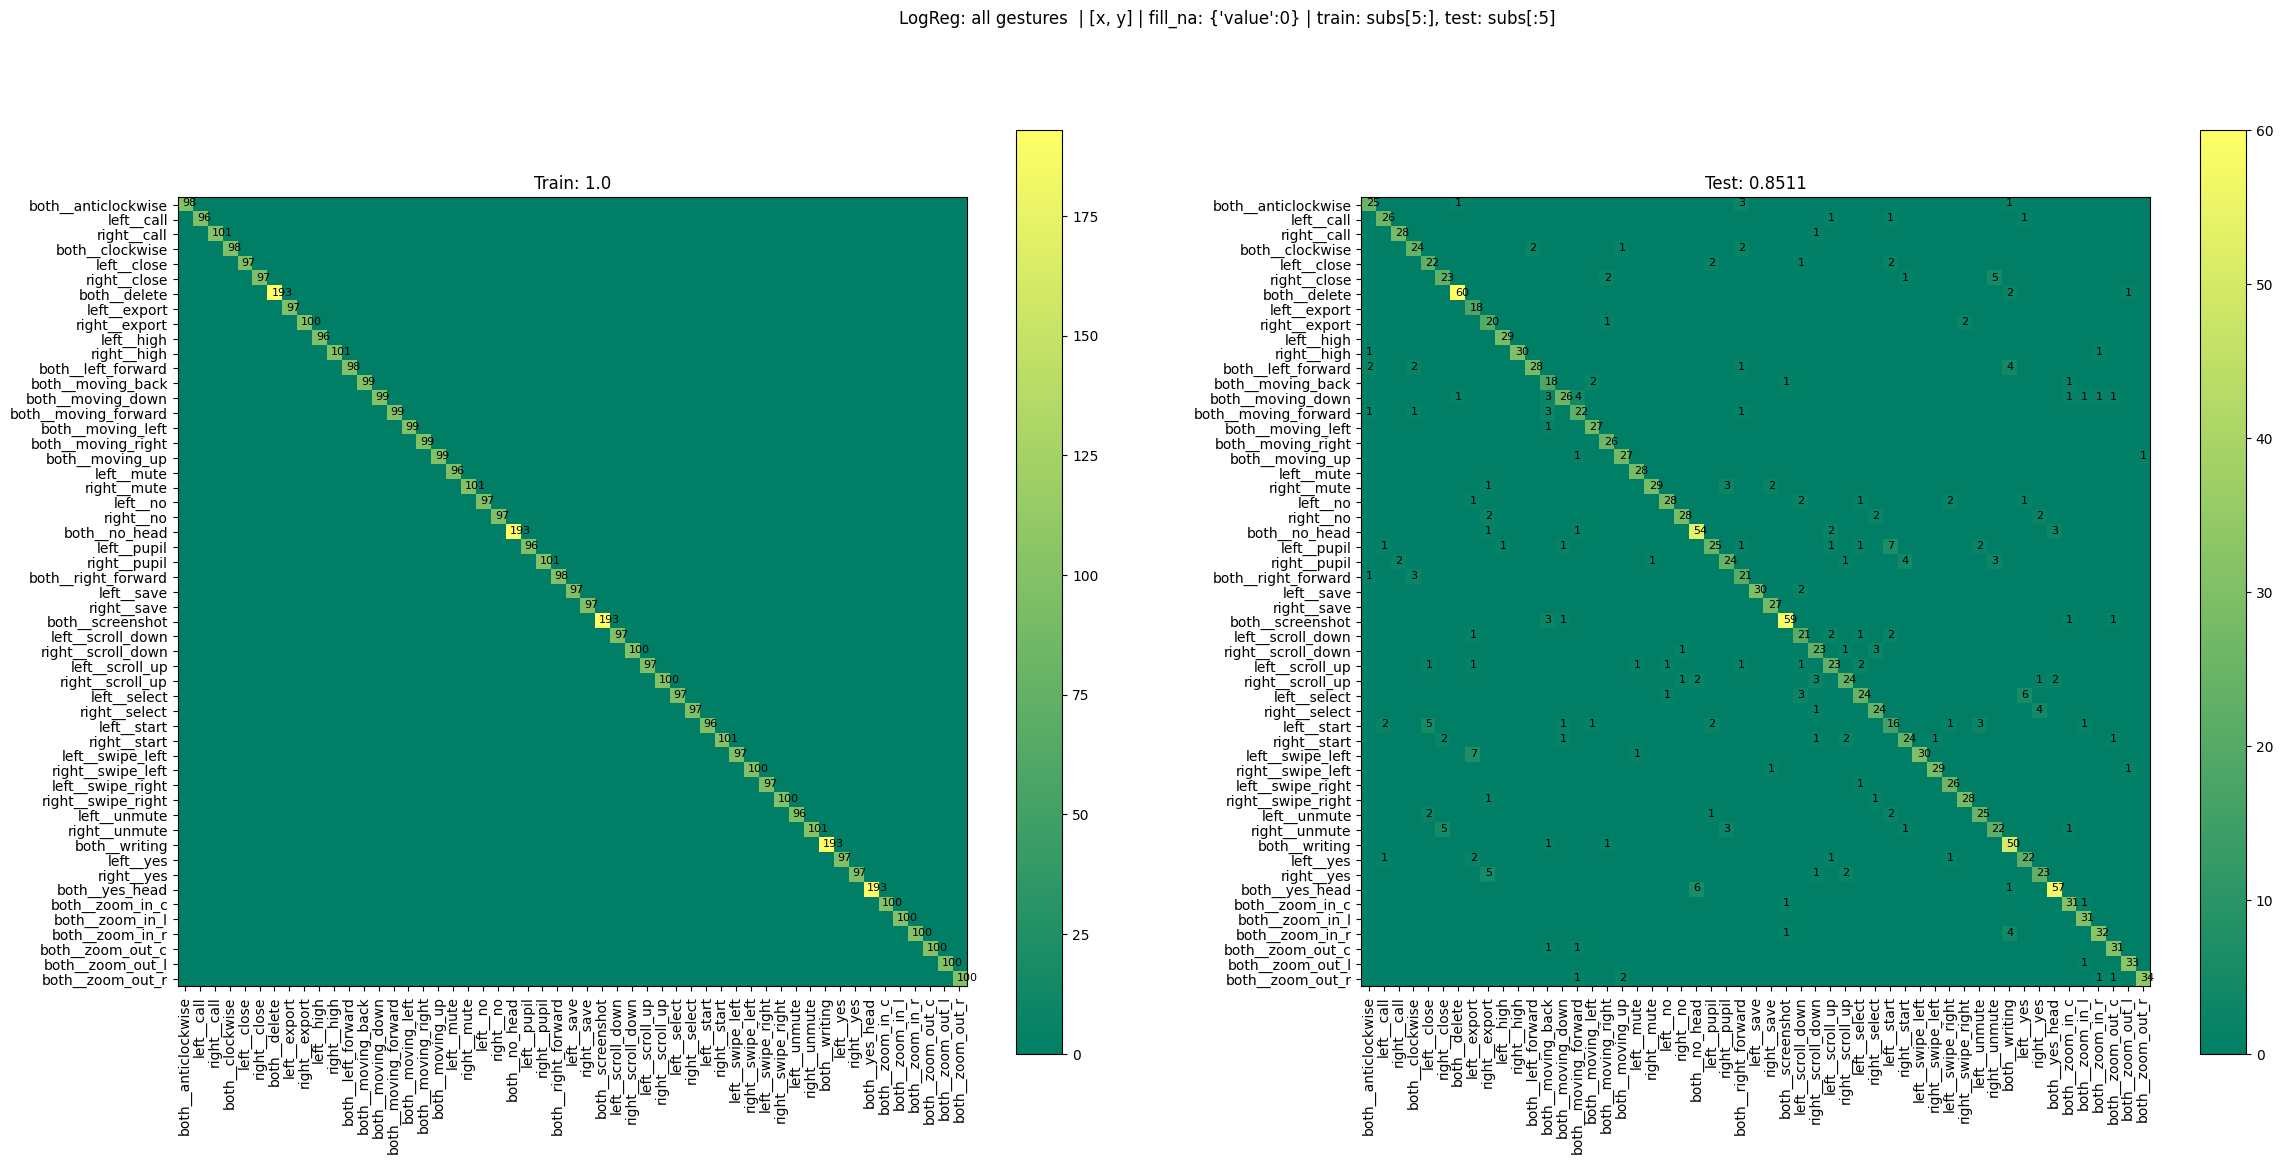

In [137]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

In [70]:
# label = model.predict(X_test)
# acc = accuracy_score(y_test, label )
# print(acc)
# plot_confusion_matrix(y_test, label, label_dict)
# plt.title('Confusion Matrix: Test data')

#### RandomForest

In [43]:
model = RandomForestClassifier(n_estimators=200)
model_name = 'RF'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200)

2
2



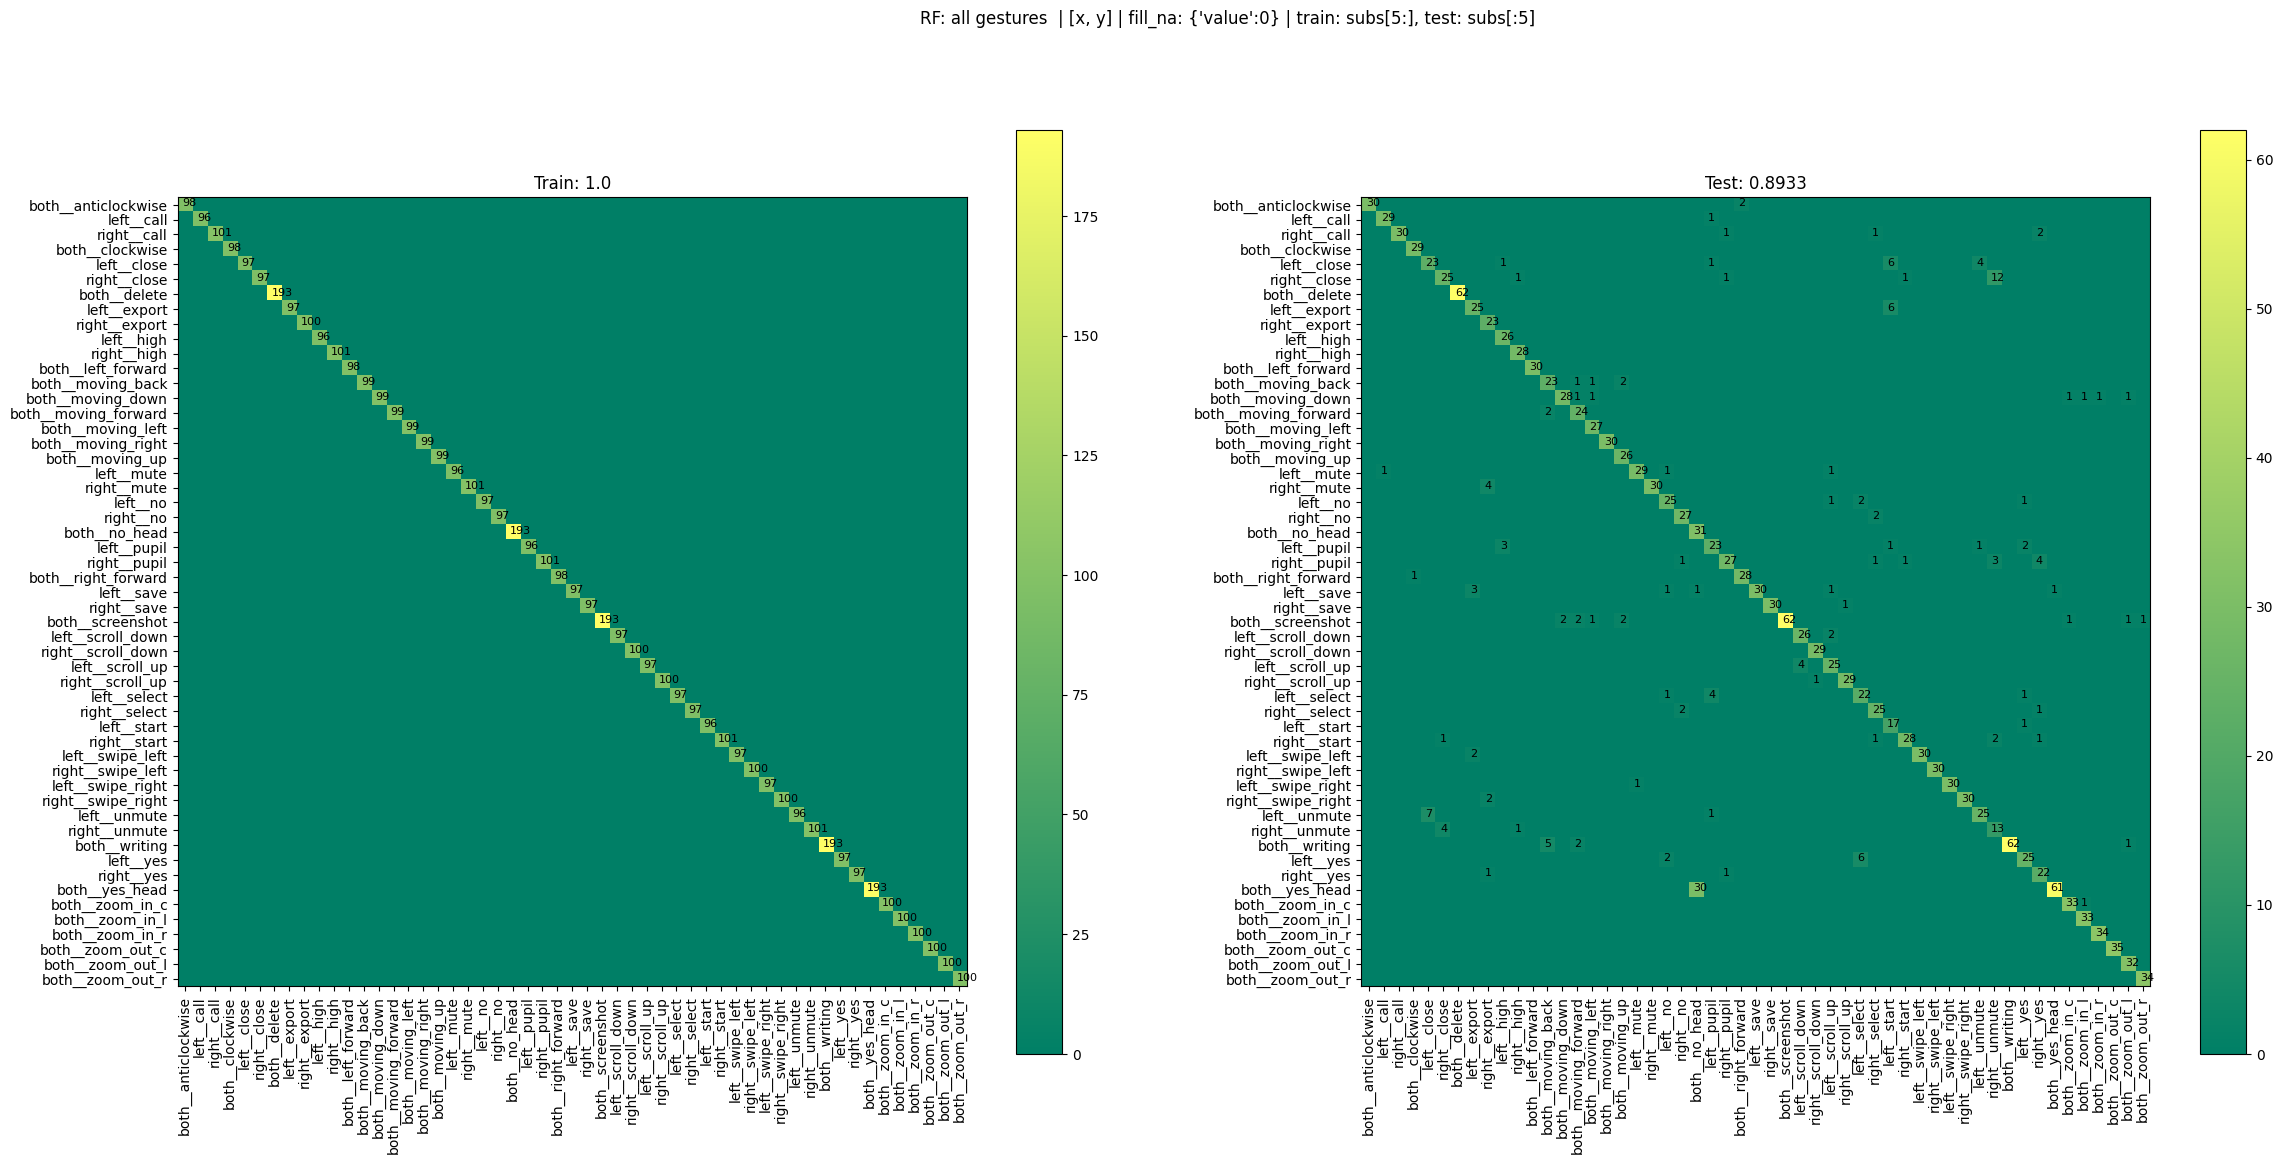

In [44]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### XGBoost 

In [41]:
model = xgb.XGBClassifier(n_estimators=200)

model_name = 'XGB'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



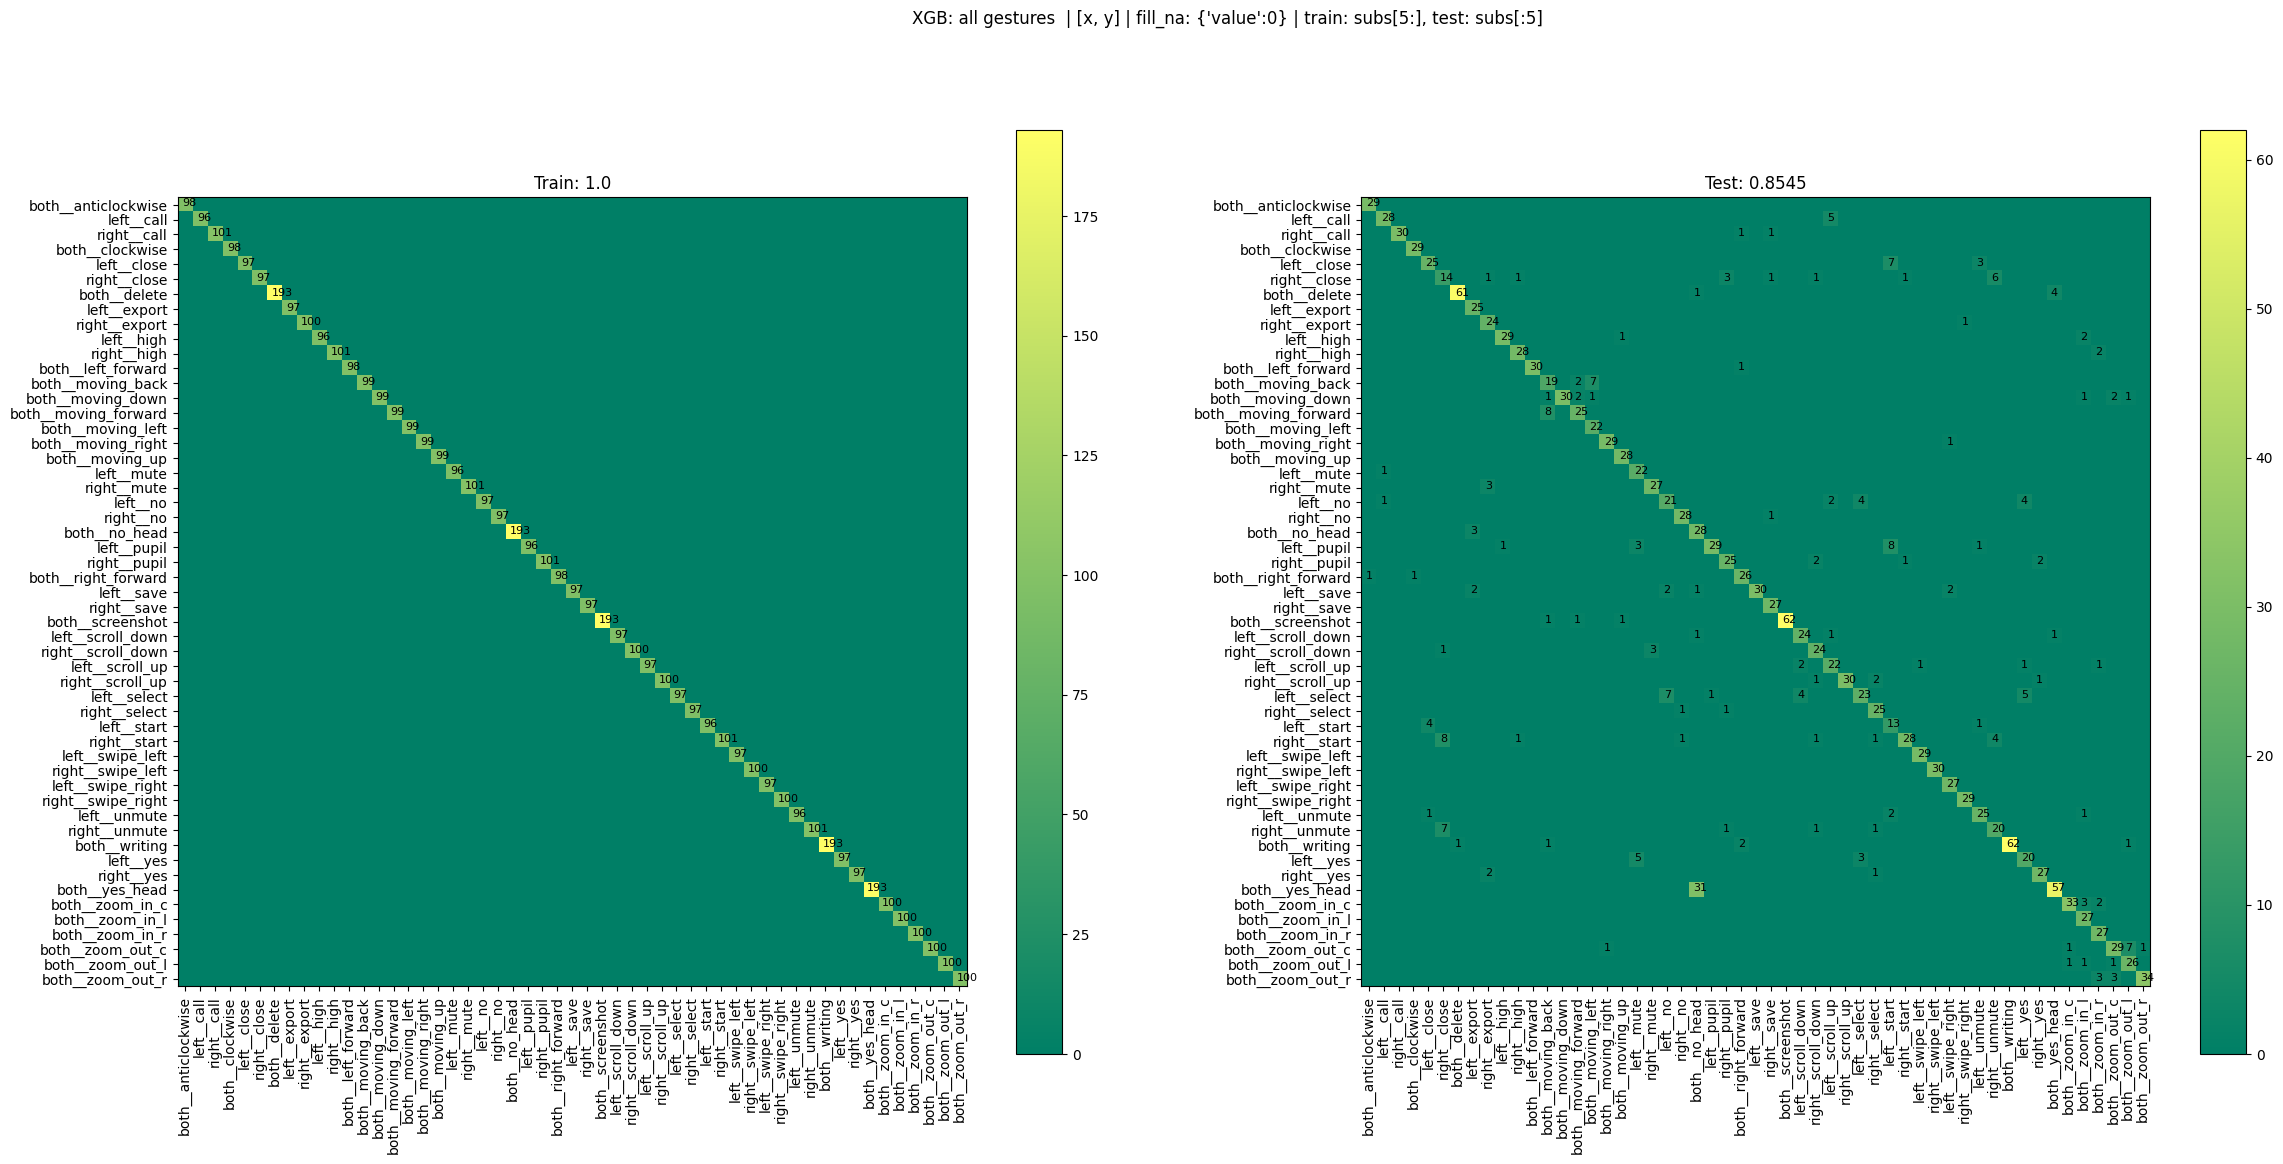

In [42]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### SVM

In [45]:
model = SVC(kernel='linear')
model_name = 'SVC'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(kernel='linear')

2
2



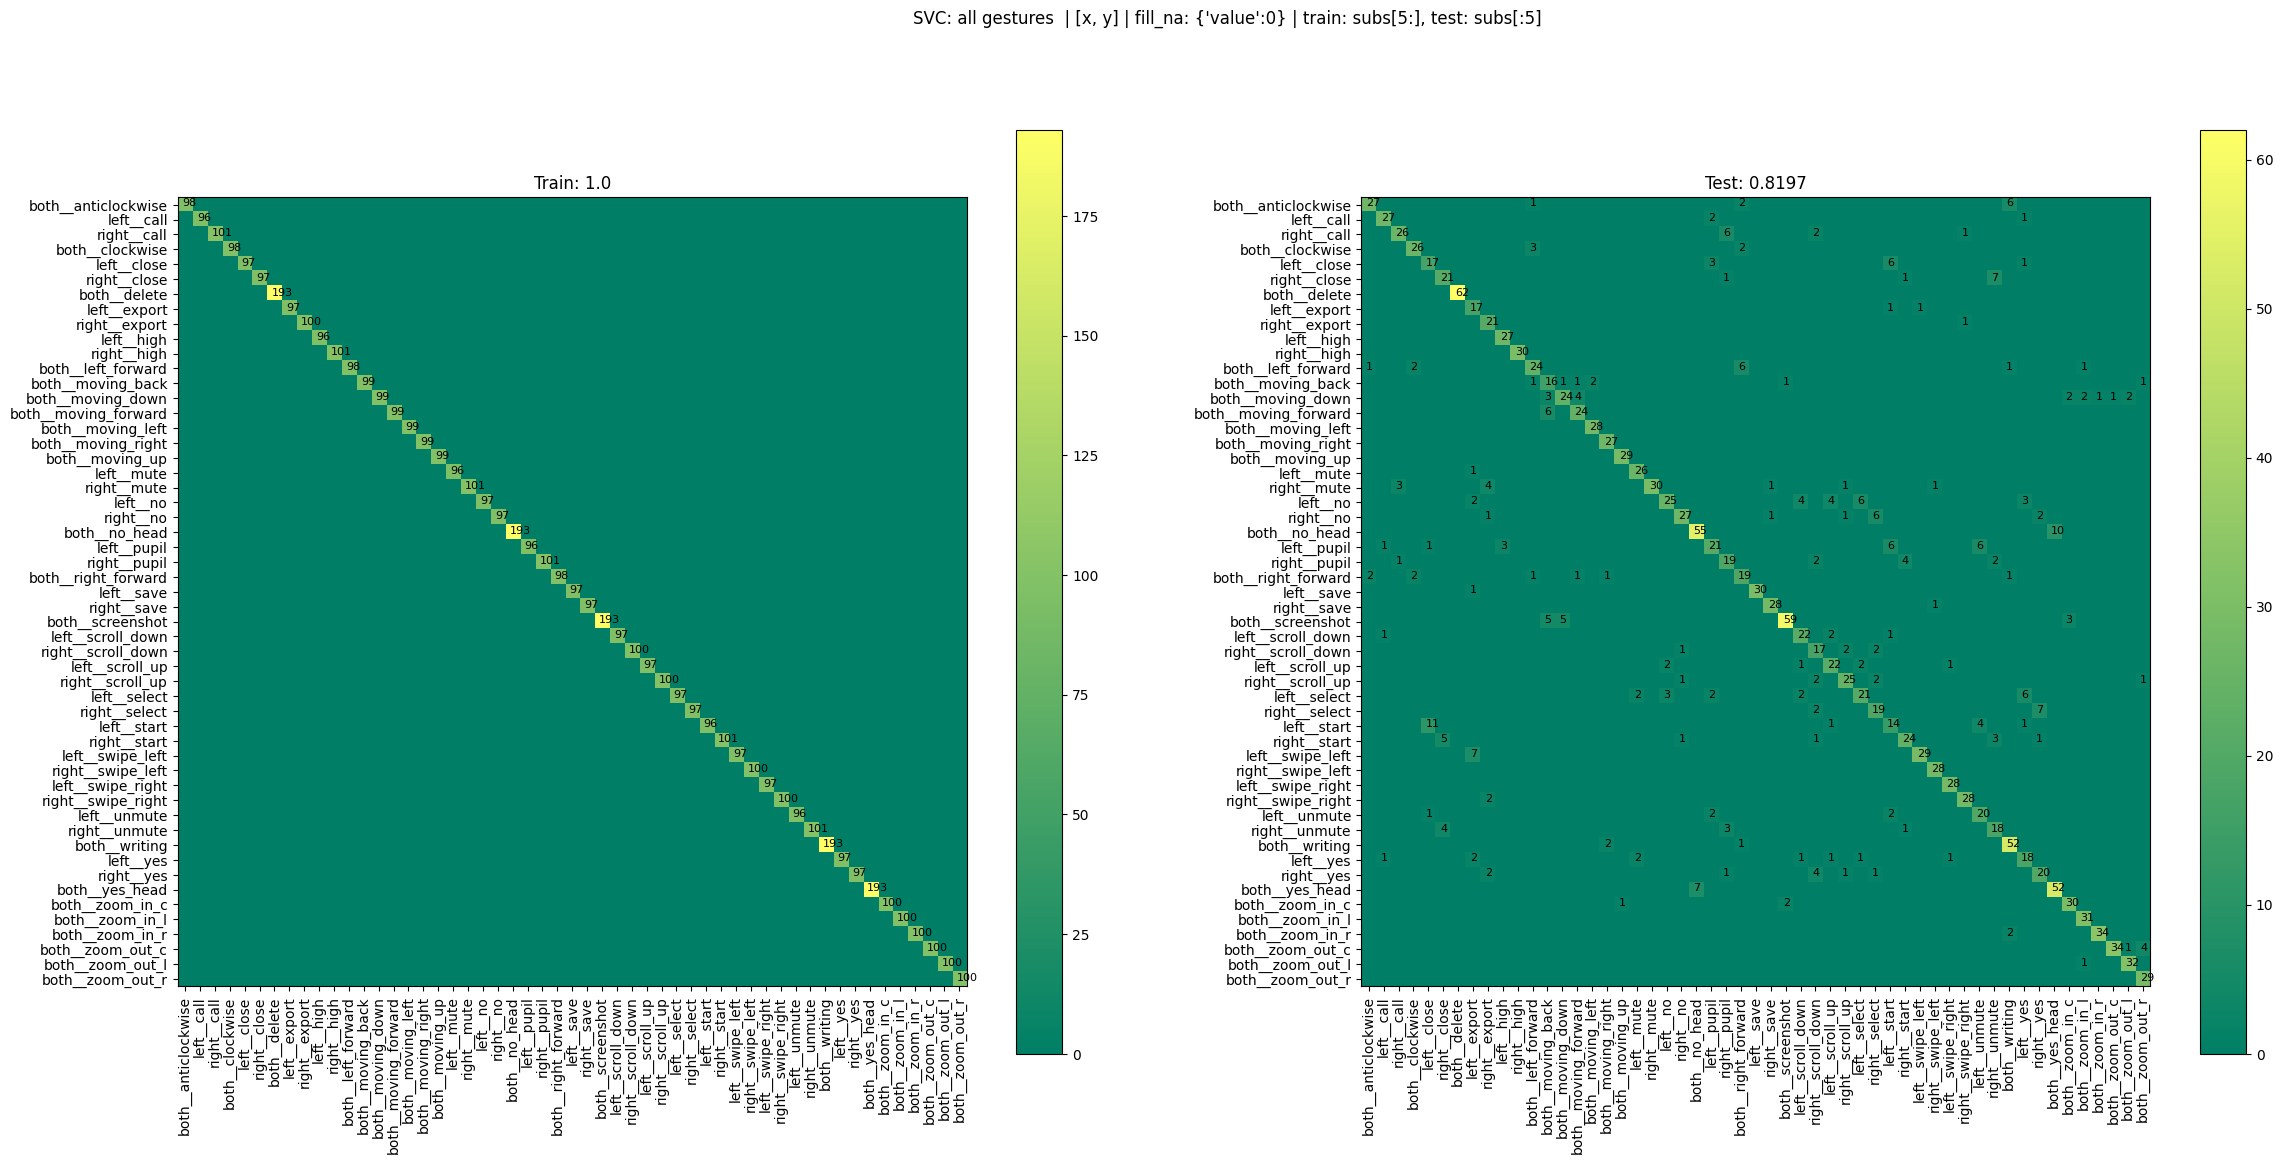

In [46]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### STM

In [58]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'STM'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = tensor
X_test = tensor_test

model.fit(X_train, y_train)

maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


STMM(maxIter=2, tol=0.01, tolSTM=0.01)

2
2



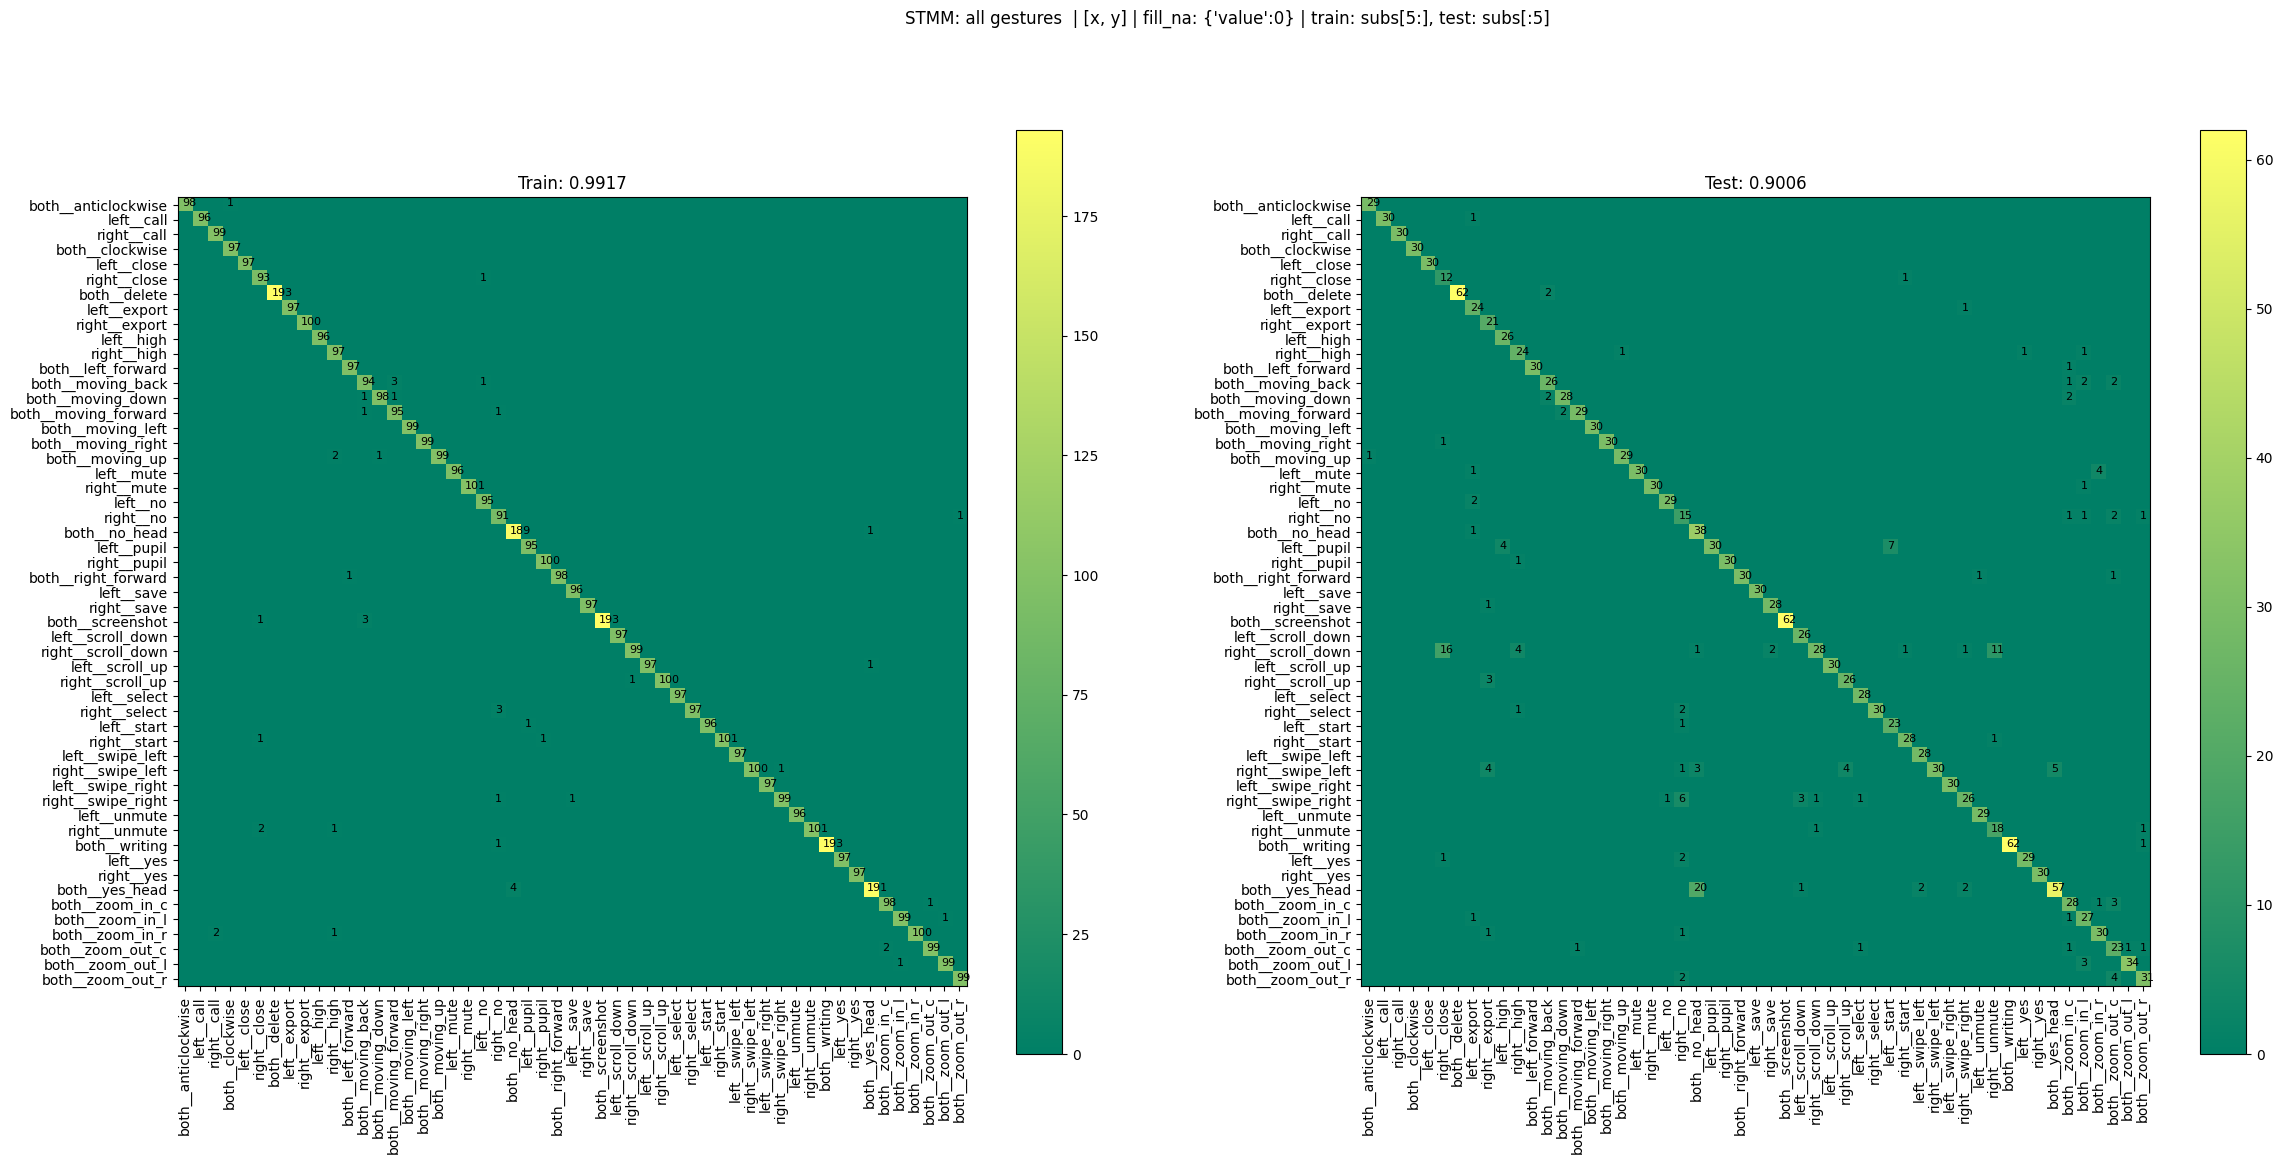

In [59]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict,)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [73]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = 'KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

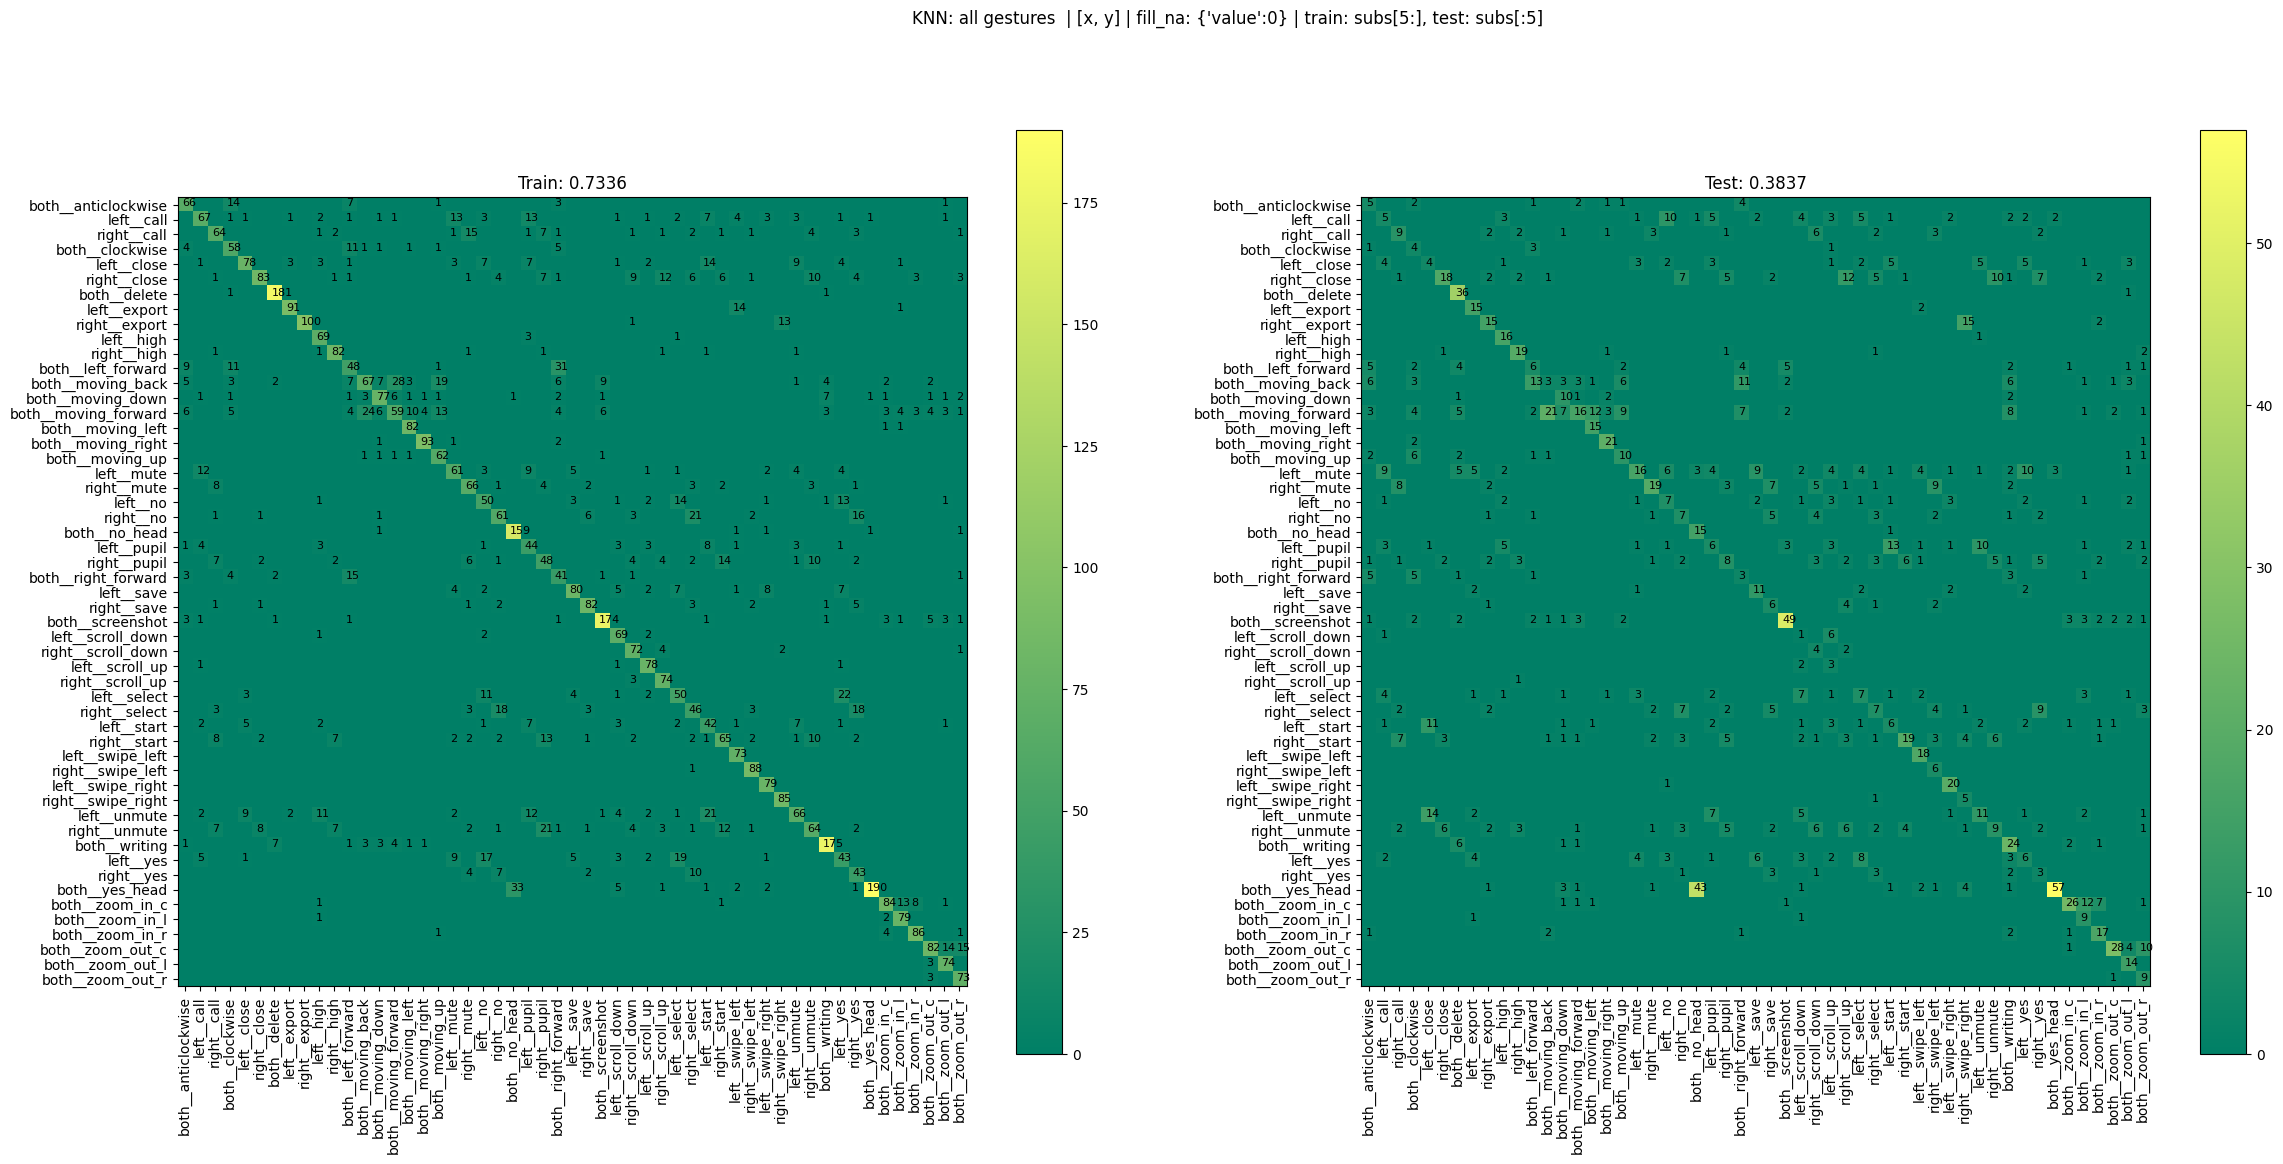

In [74]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

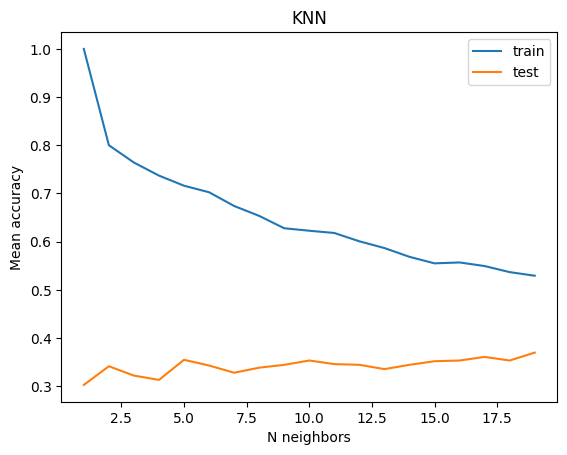

In [306]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

### After SVD

In [55]:
tensor = matrix_SVD
tensor_test = matrix_SVD_test
pref = 'SVD+'

#### LogReg

In [74]:
model = LogisticRegression(max_iter=1000, C=1, solver='lbfgs', class_weight='balanced')
model_name = 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

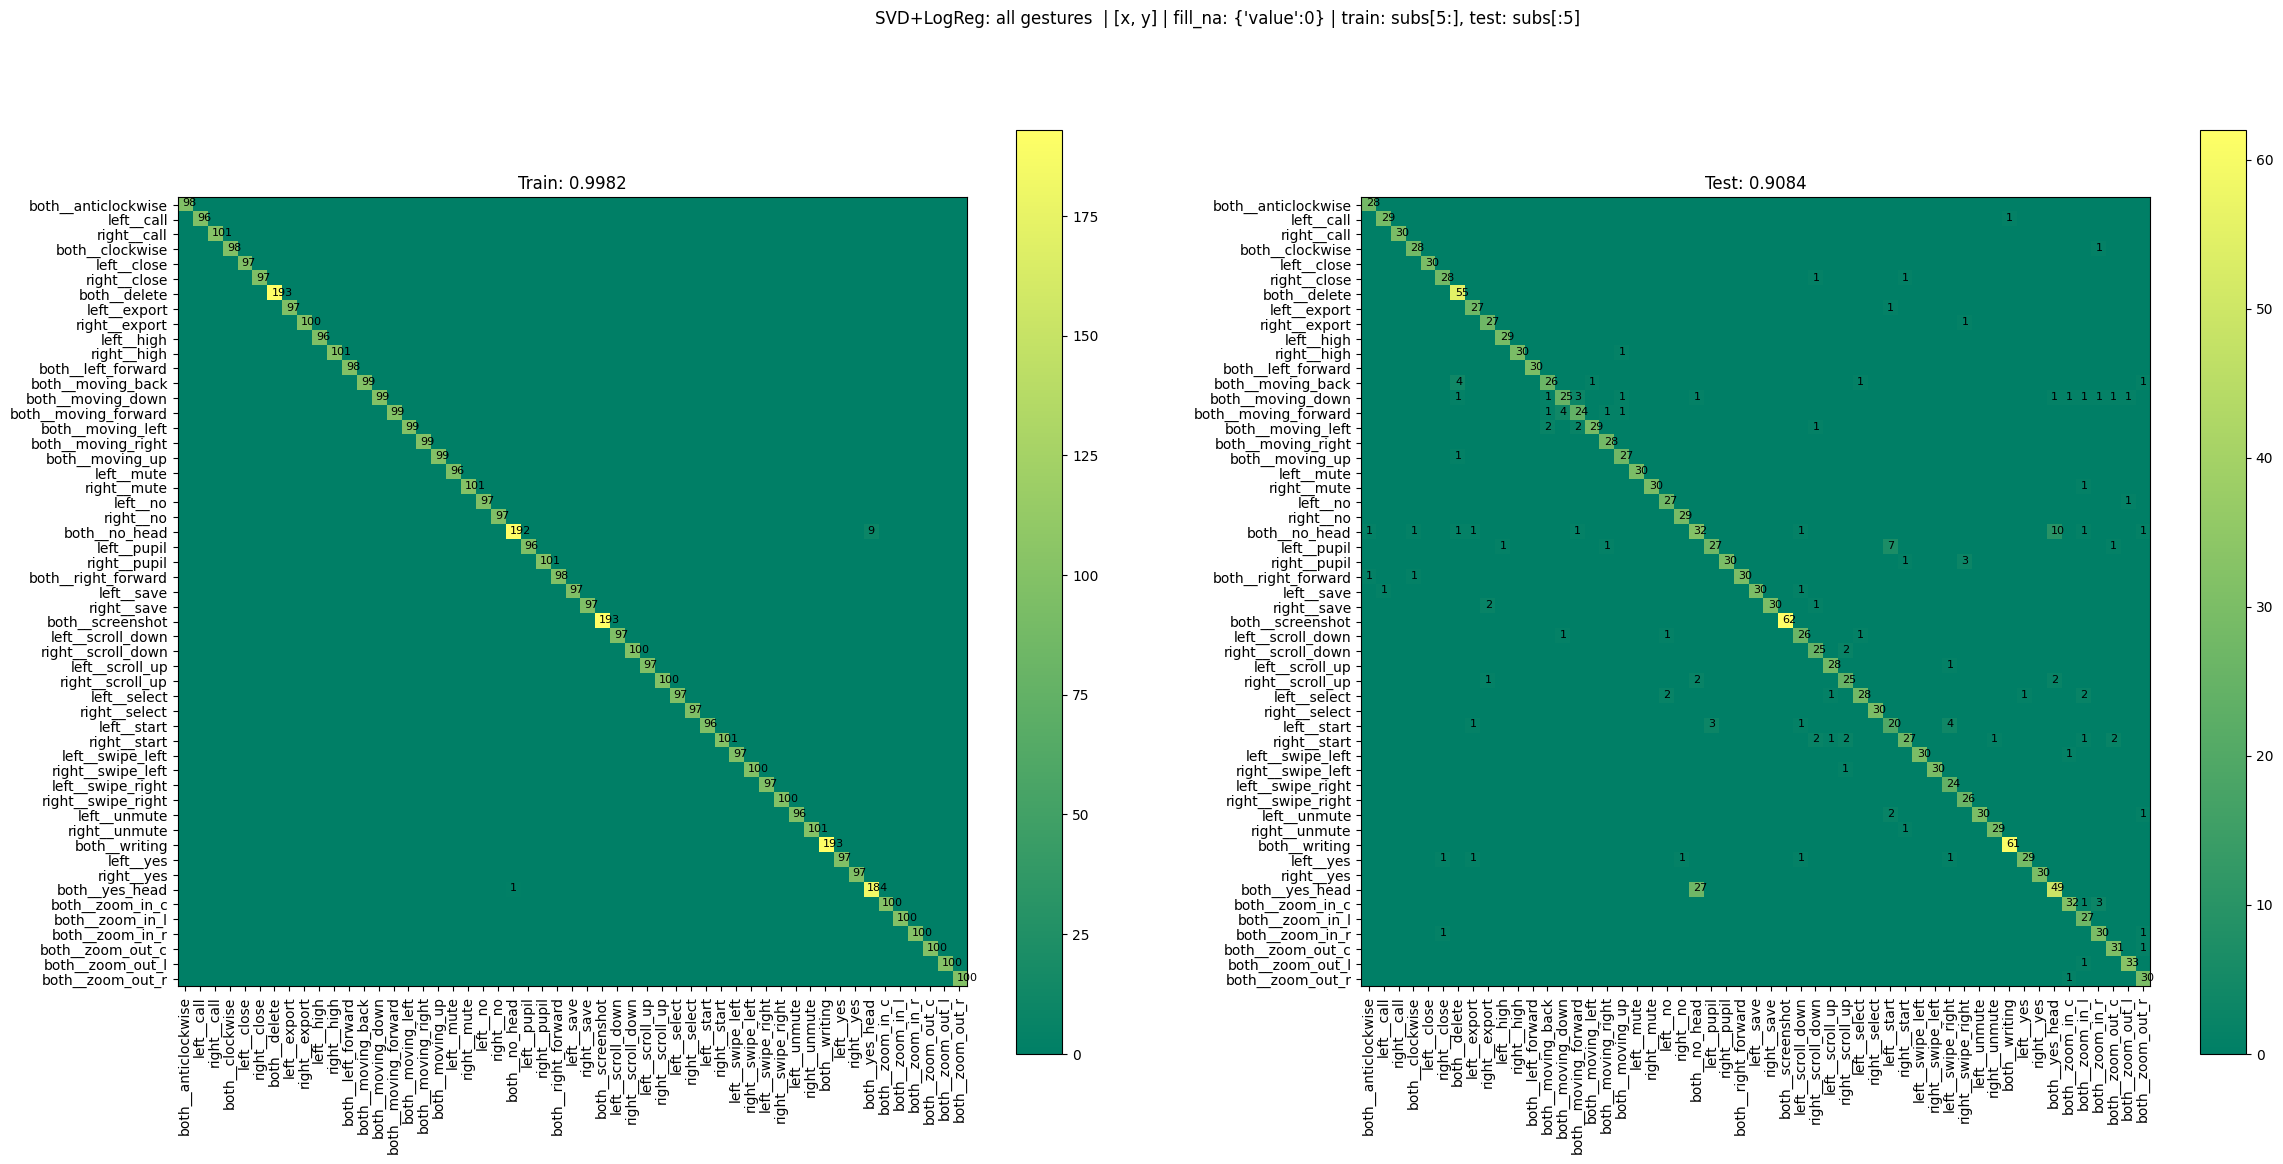

In [75]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig)

#### Random Forest

In [58]:
model = RandomForestClassifier(n_estimators=200)
model_name = 'RF'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

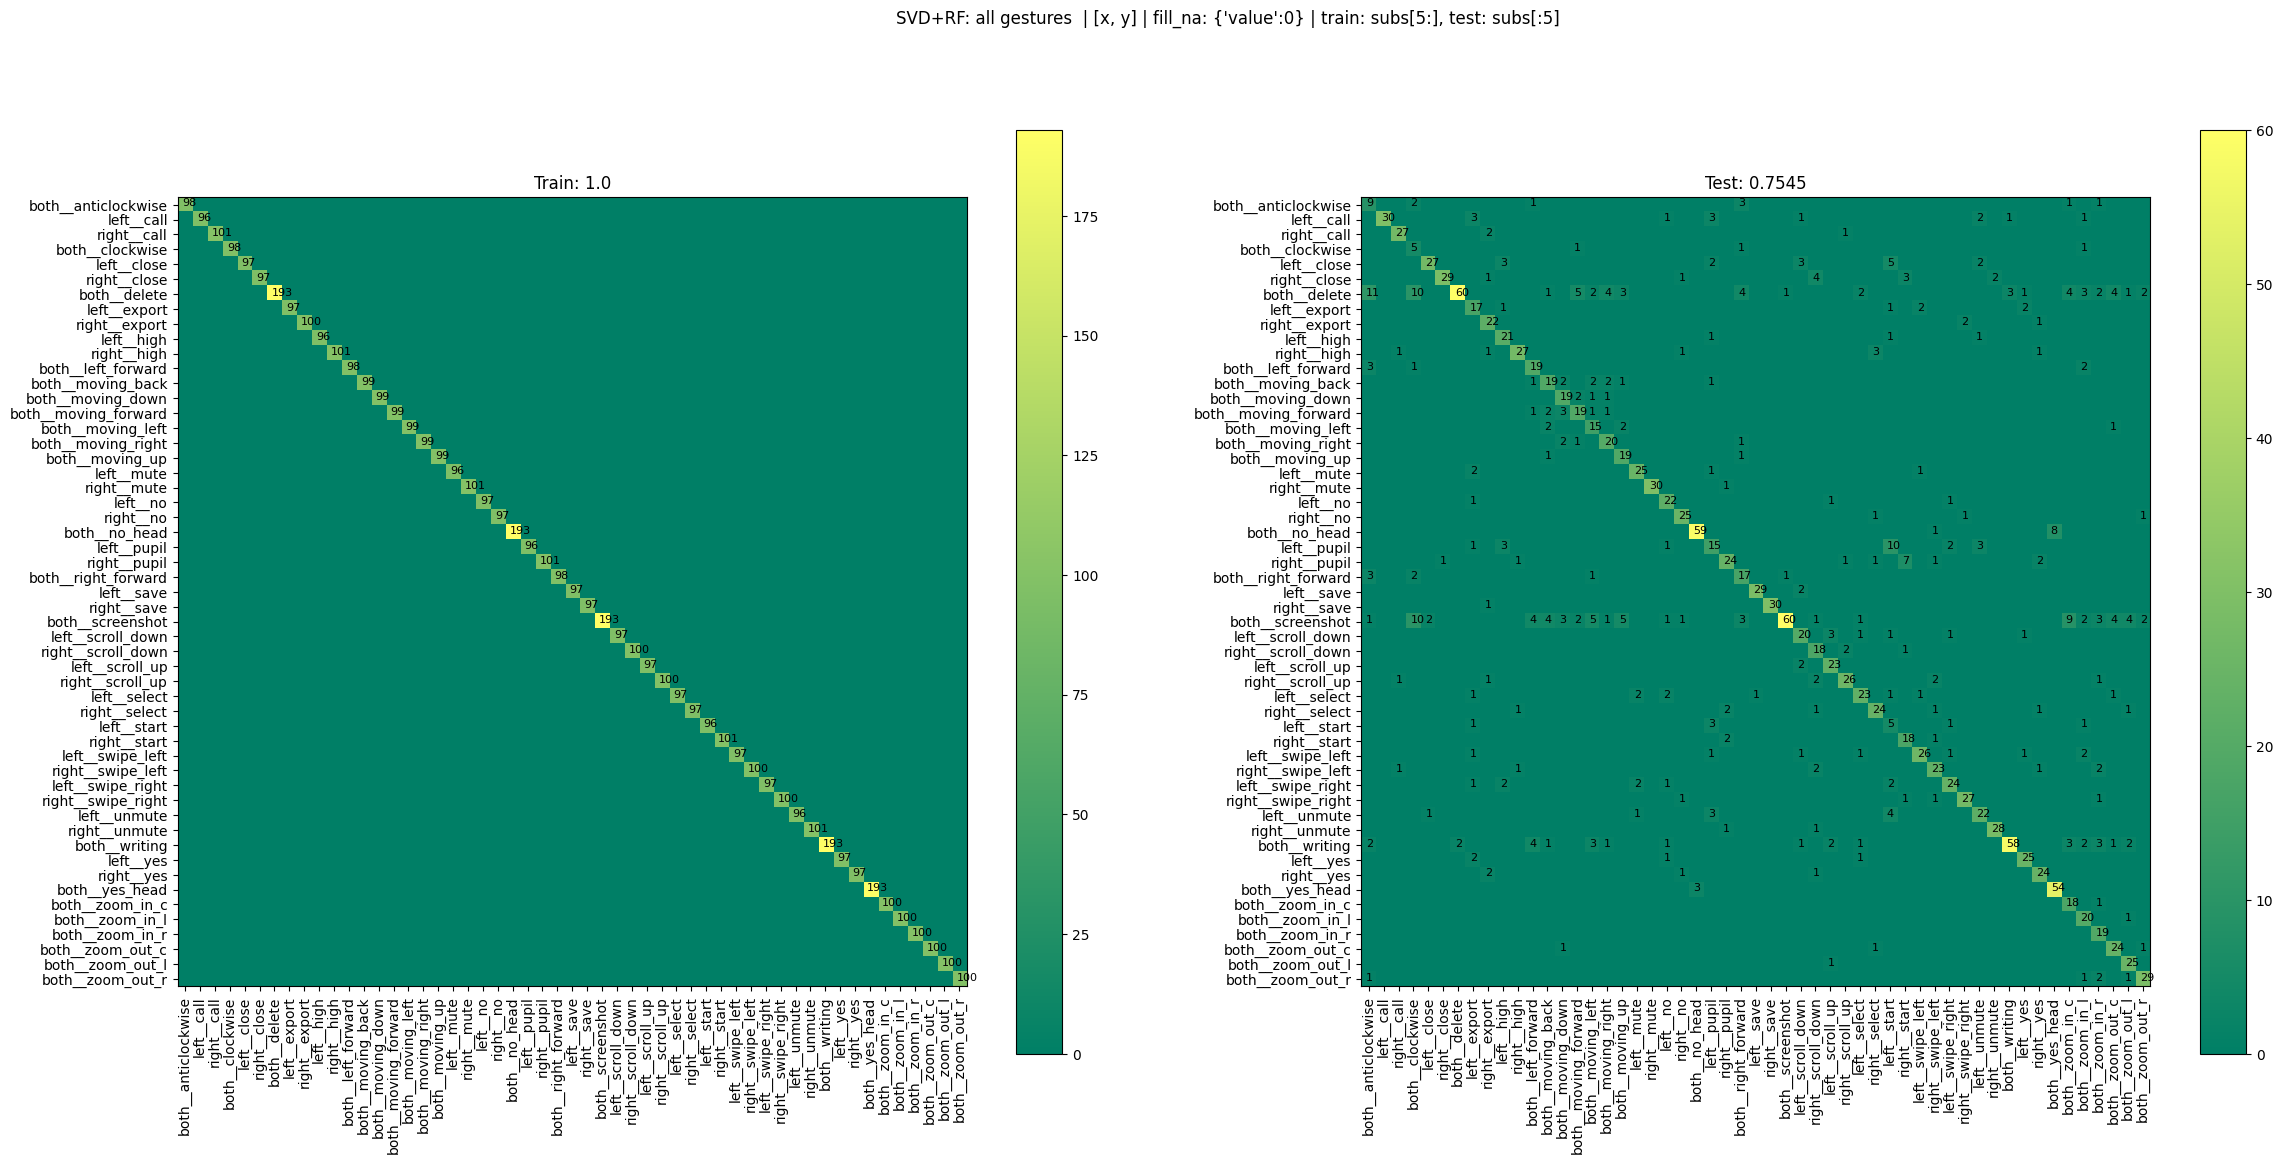

In [59]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig)

#### XGBoost

In [60]:
model = xgb.XGBClassifier(n_estimators=300)
model_name = 'XGB'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

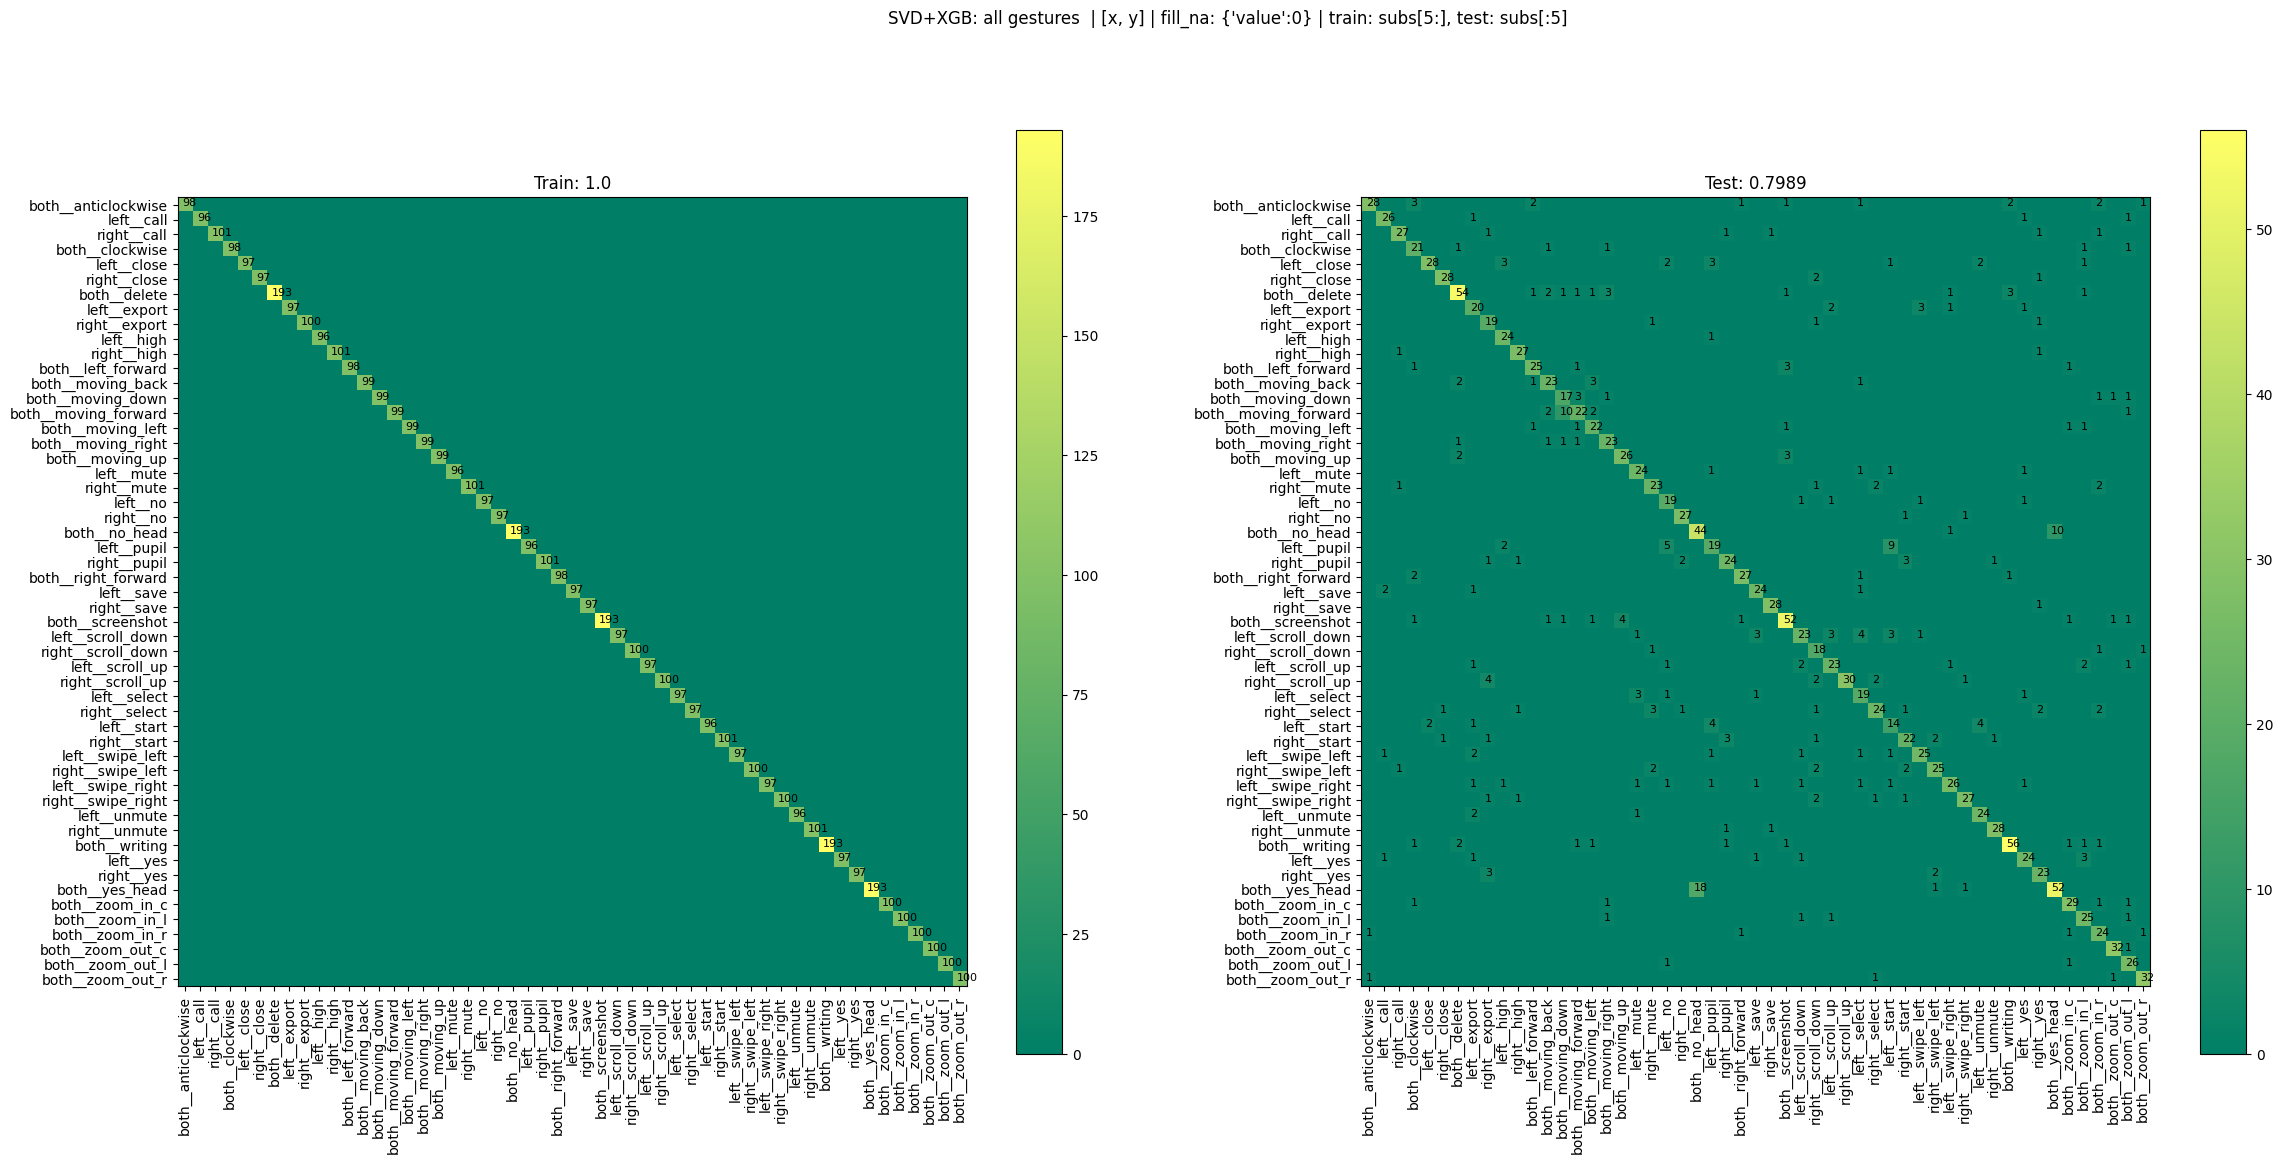

In [61]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig)

#### SVM

In [62]:
model = SVC(kernel='linear')
model_name = 'SVC'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

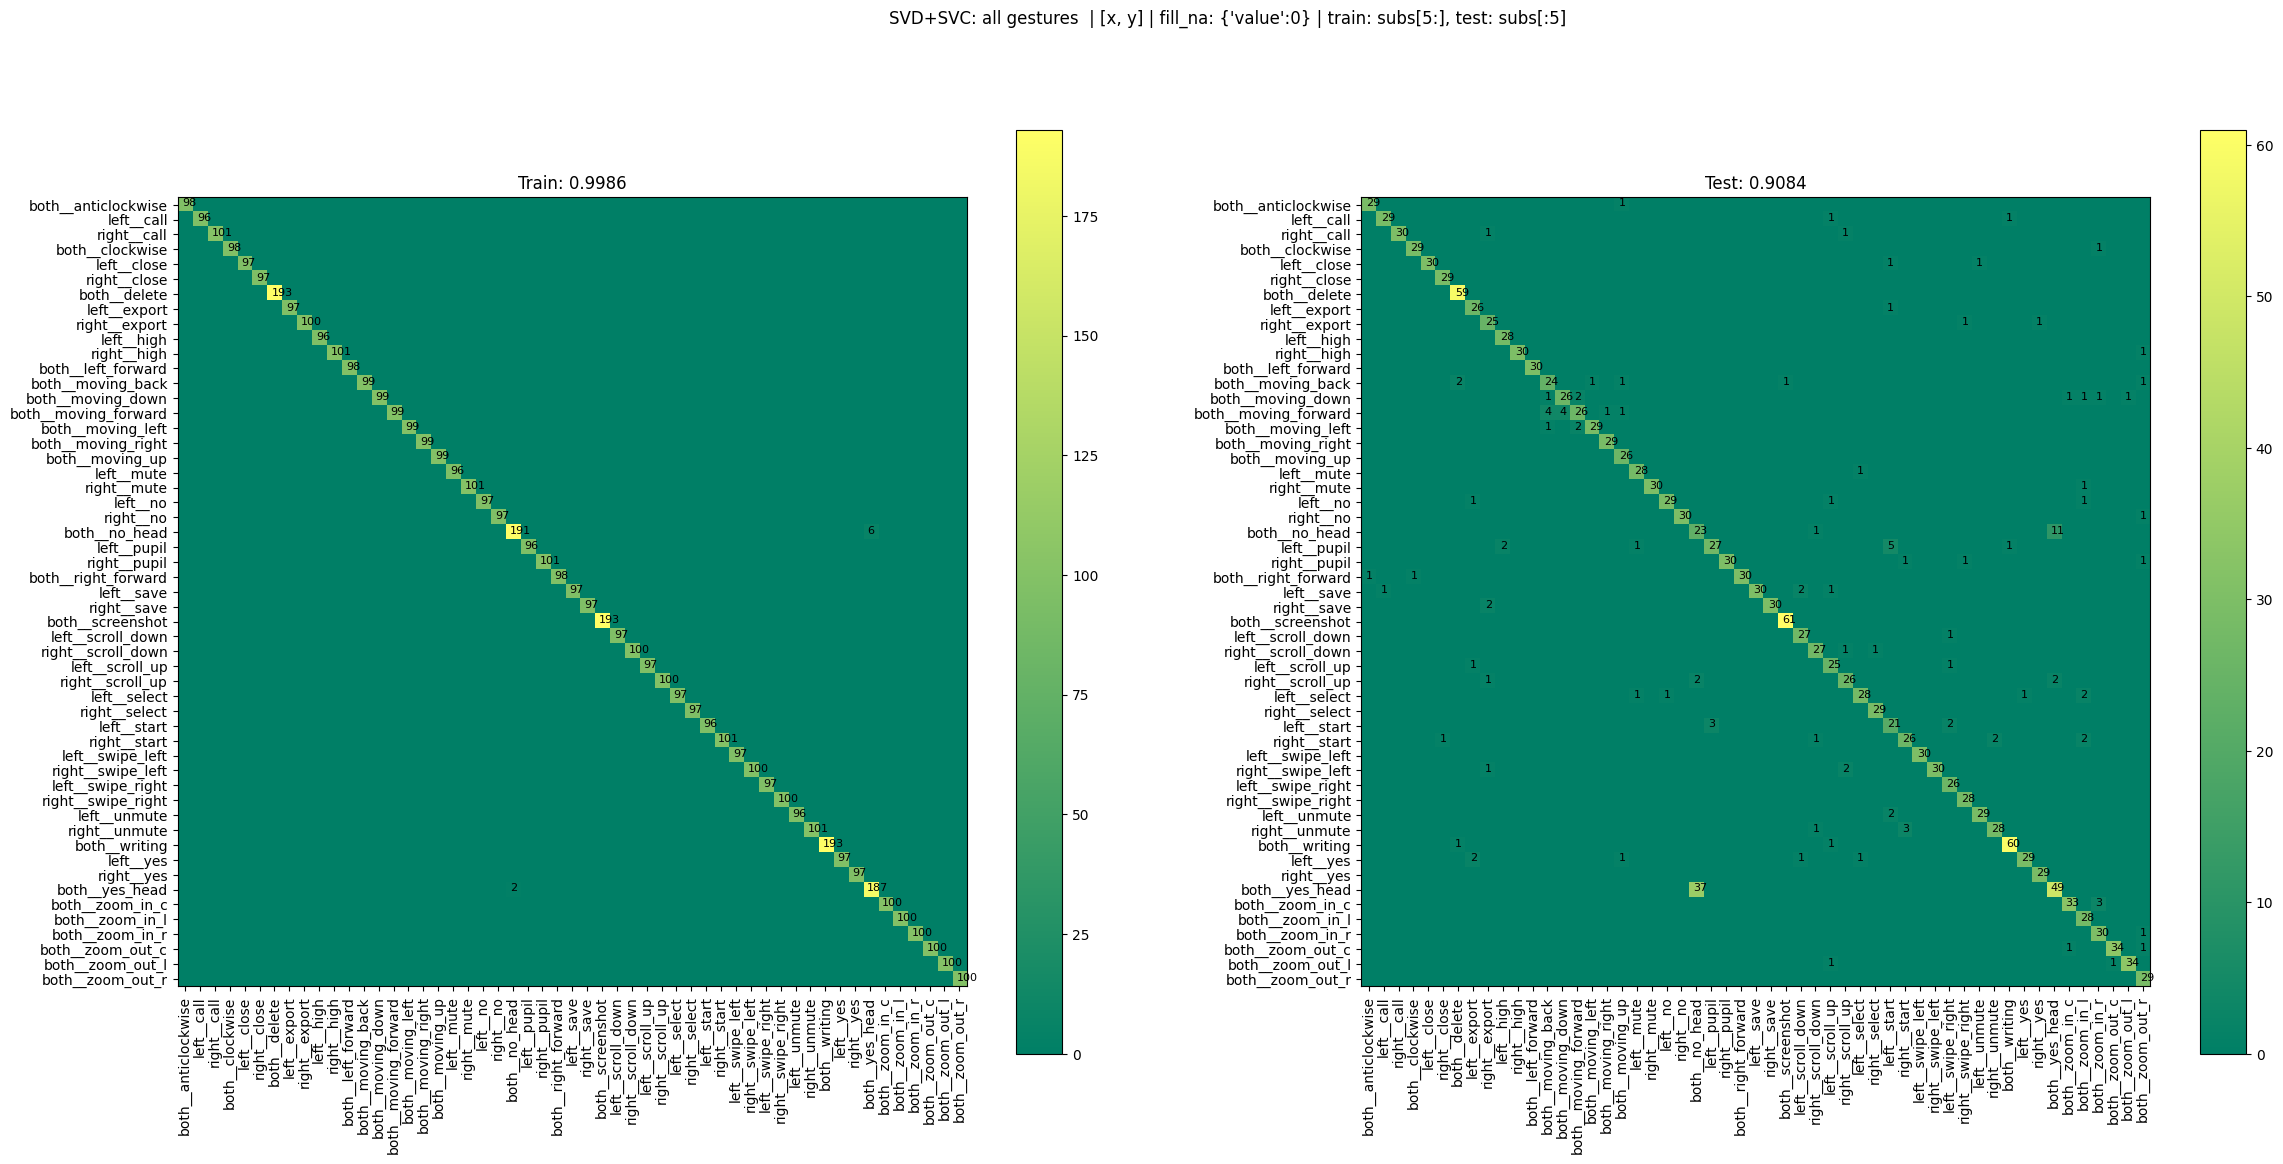

In [63]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig)

#### STM

In [227]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'STM'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
Tensor ML model is used!
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


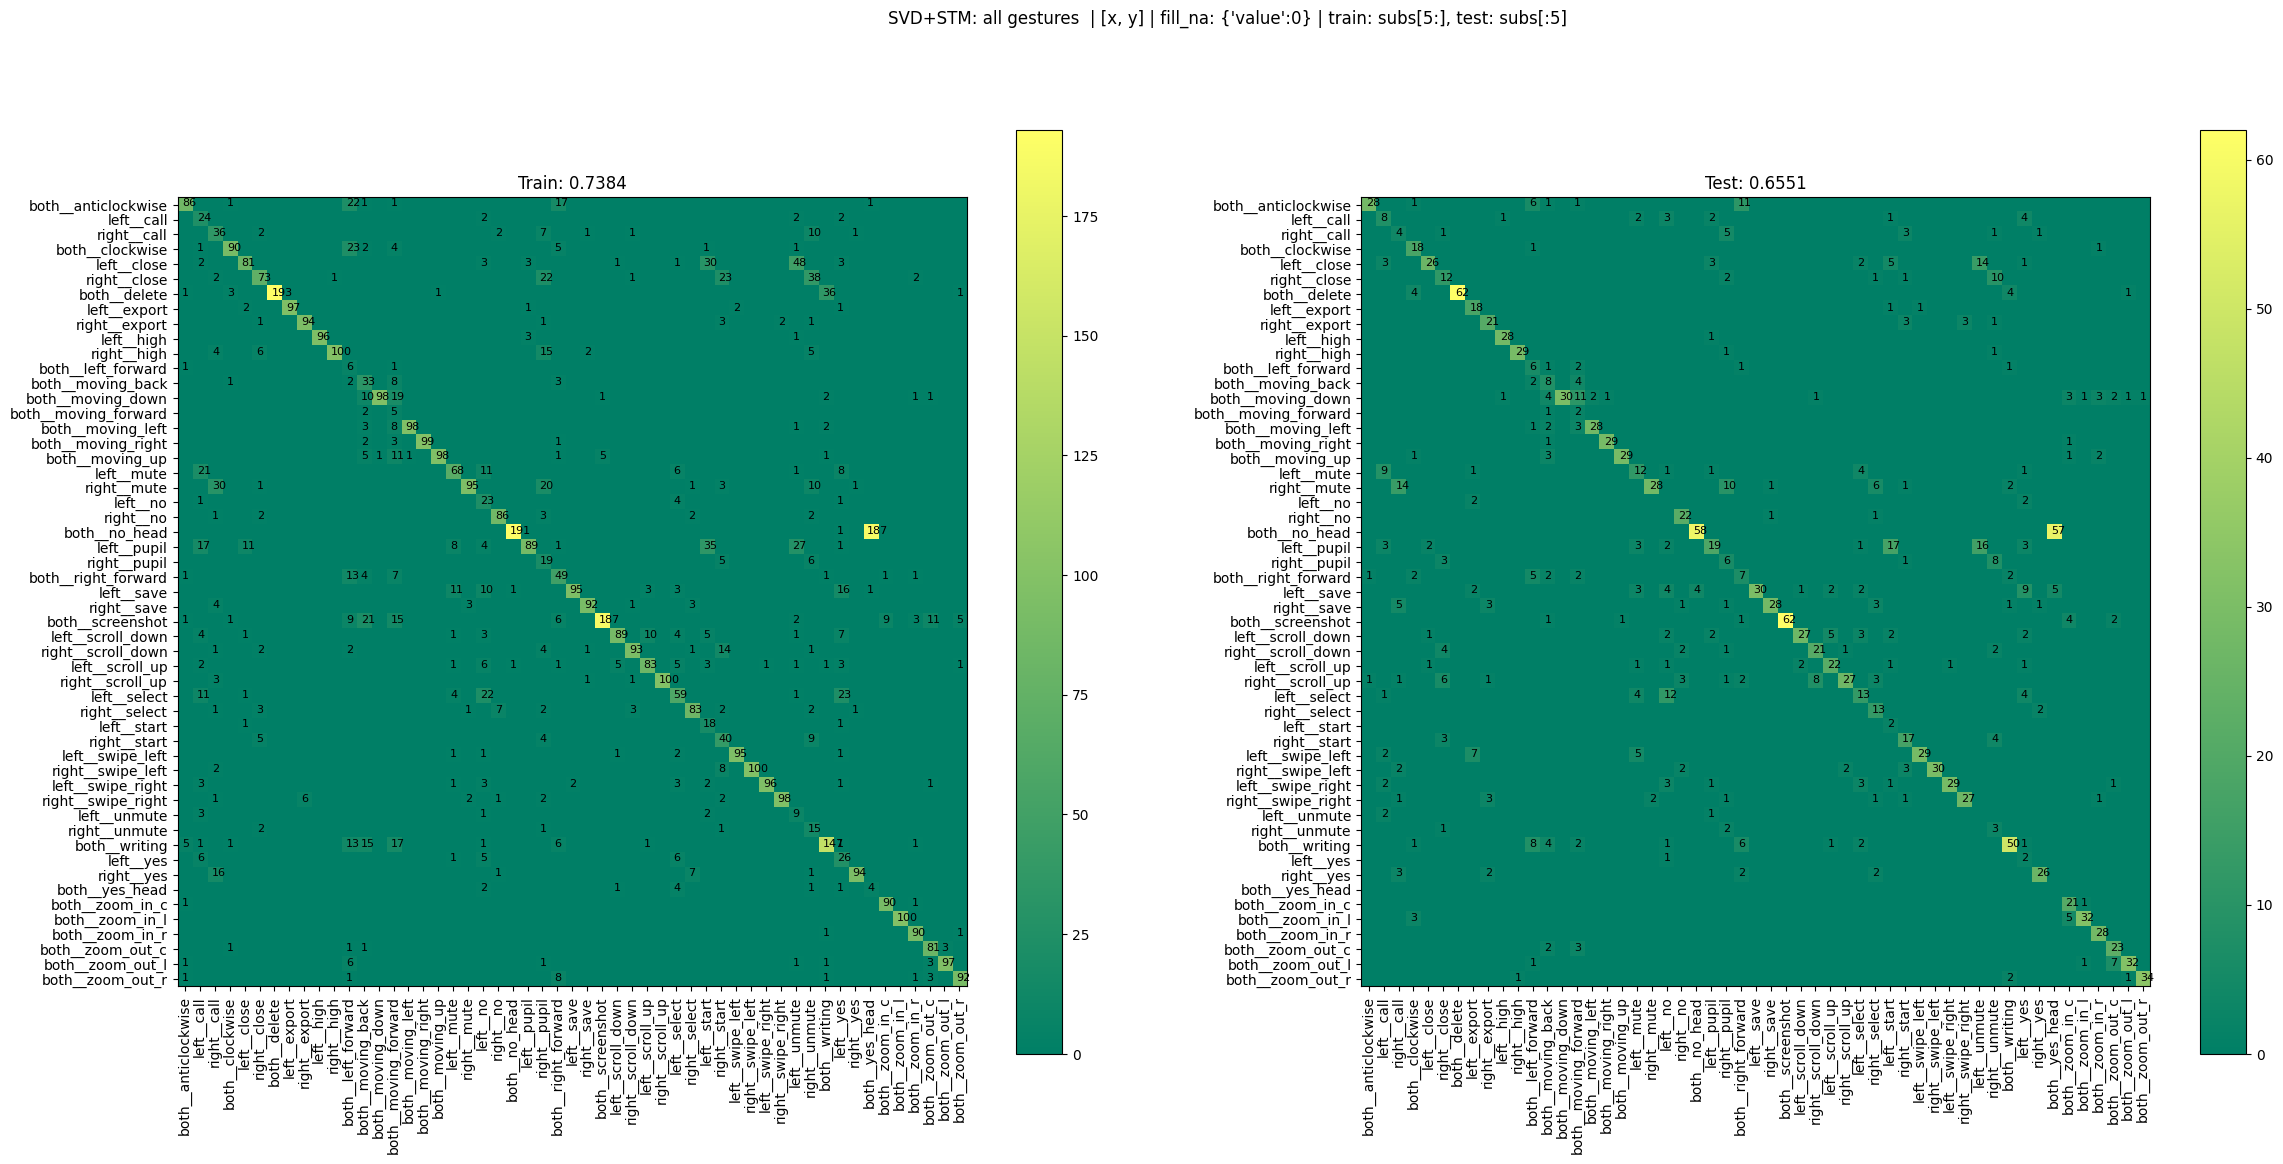

In [230]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig)

#### KNN

In [162]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = 'KNN'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

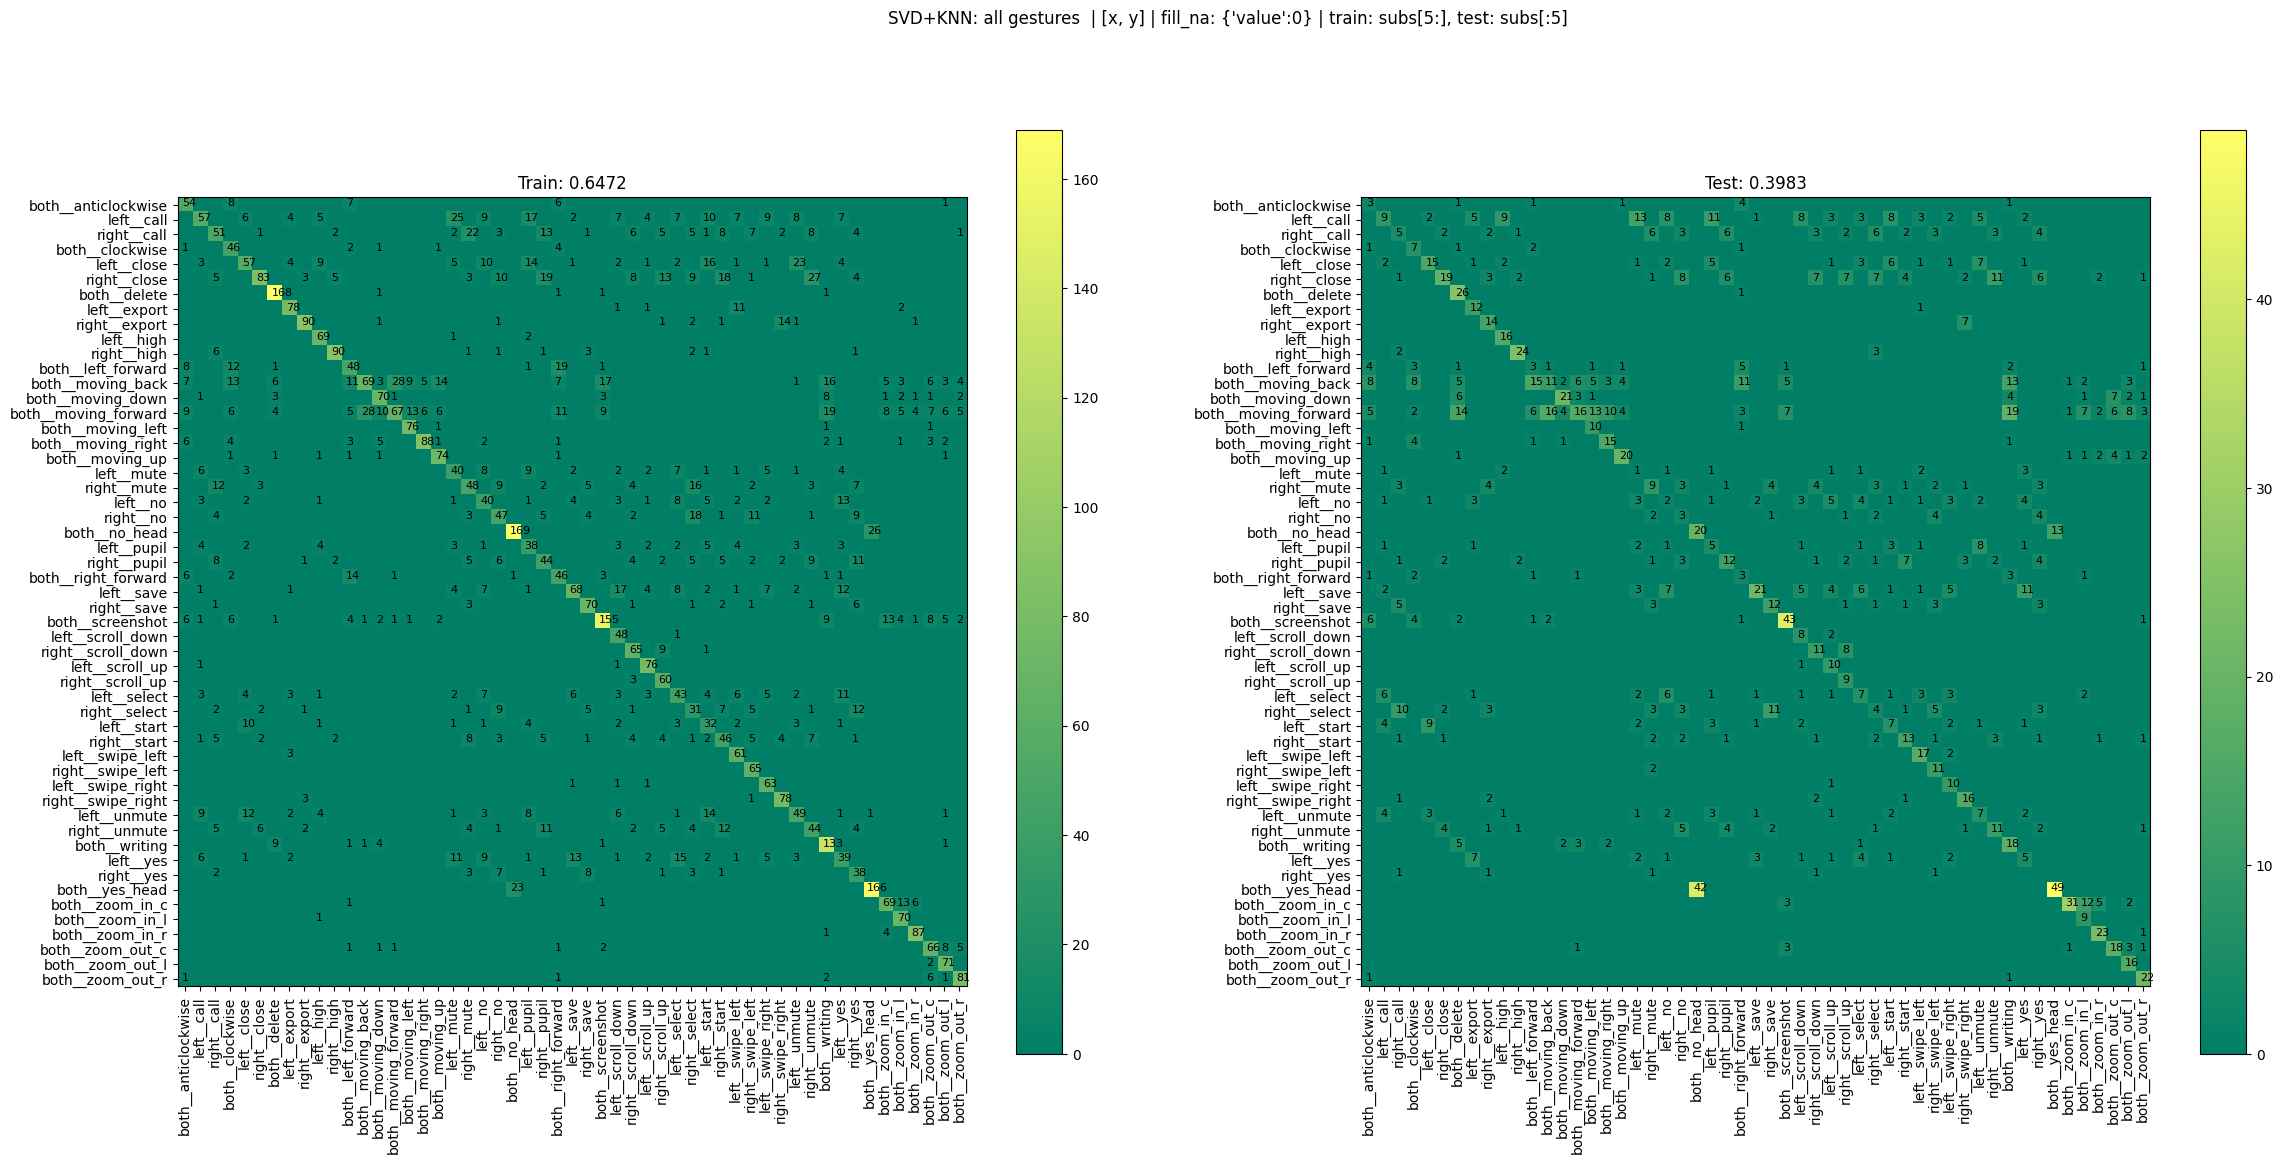

In [163]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig)

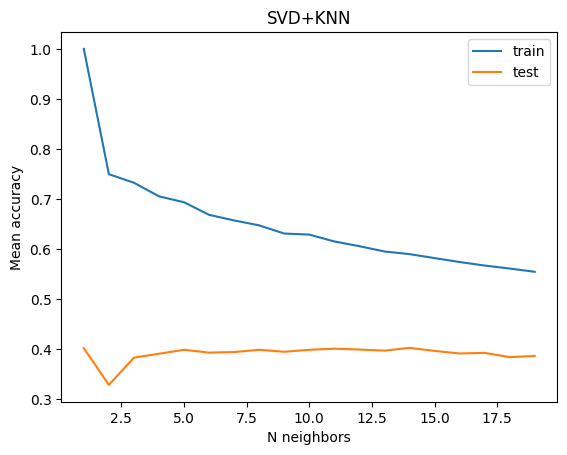

In [164]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

### After CPD

In [ ]:
tensor = tensor_CPD
tensor_test = tensor_CPD_test
pref = 'CPD+'

#### LogReg

In [271]:
model = LogisticRegression(max_iter=1000)
model_name = 'CPD + LogReg'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

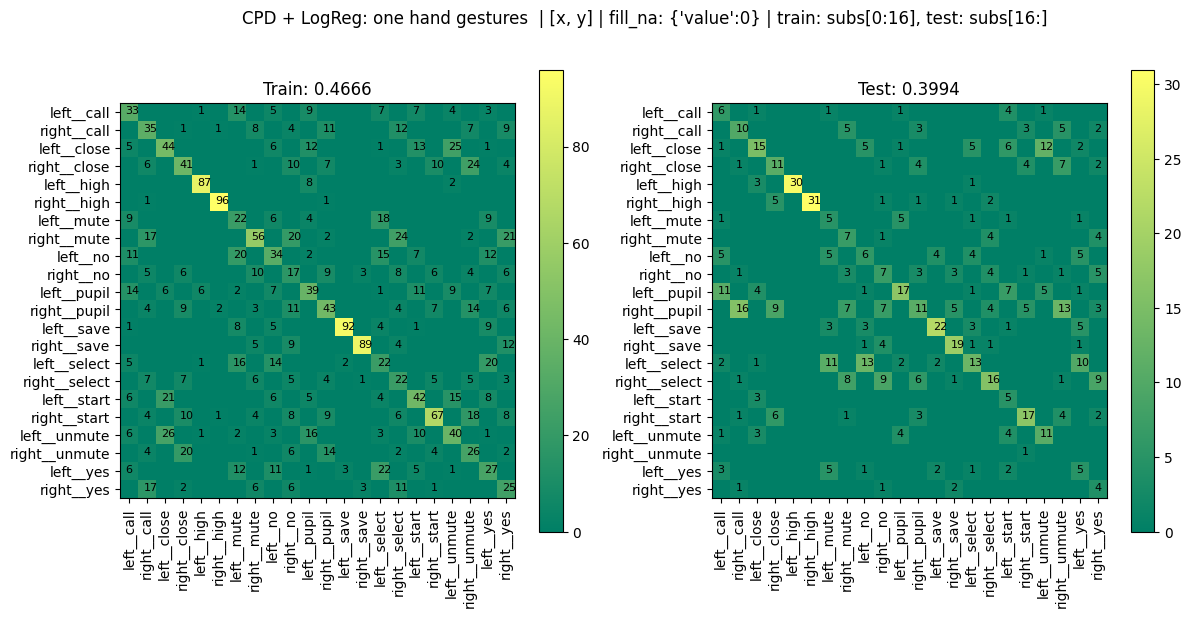

In [272]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [302]:
model = KNeighborsClassifier(n_neighbors=14)
model_name = 'CPD + KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=14)

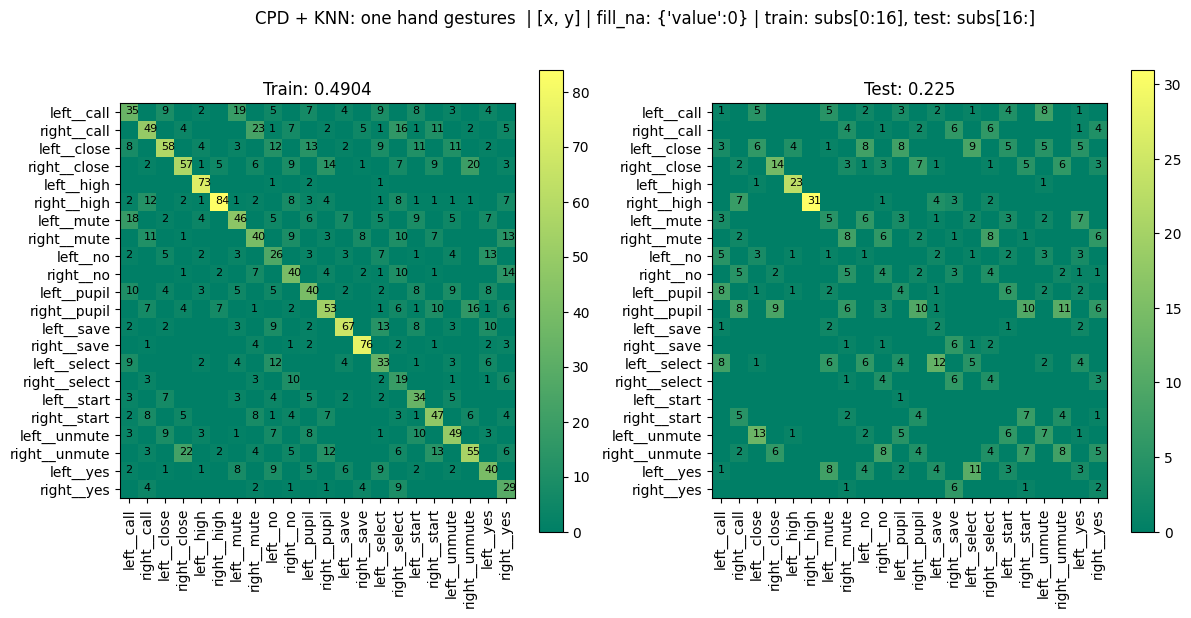

In [303]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

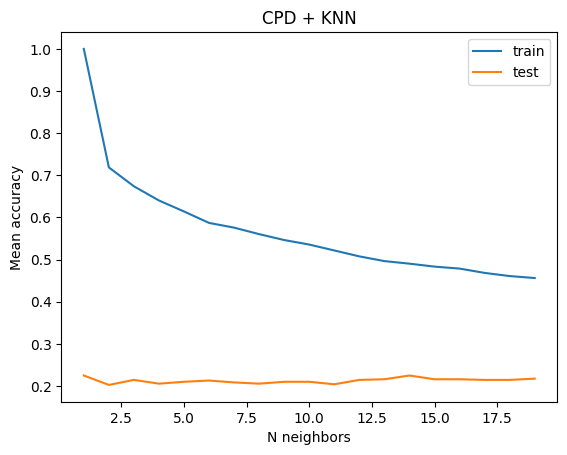

In [296]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  

### After Tucker

In [19]:
tensor = tensor_tucker
tensor_test = tensor_tucker_test
pref = 'Tucker+'

#### LogReg

In [20]:
model = LogisticRegression(max_iter=200)
model_name = pref + 'LogReg'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

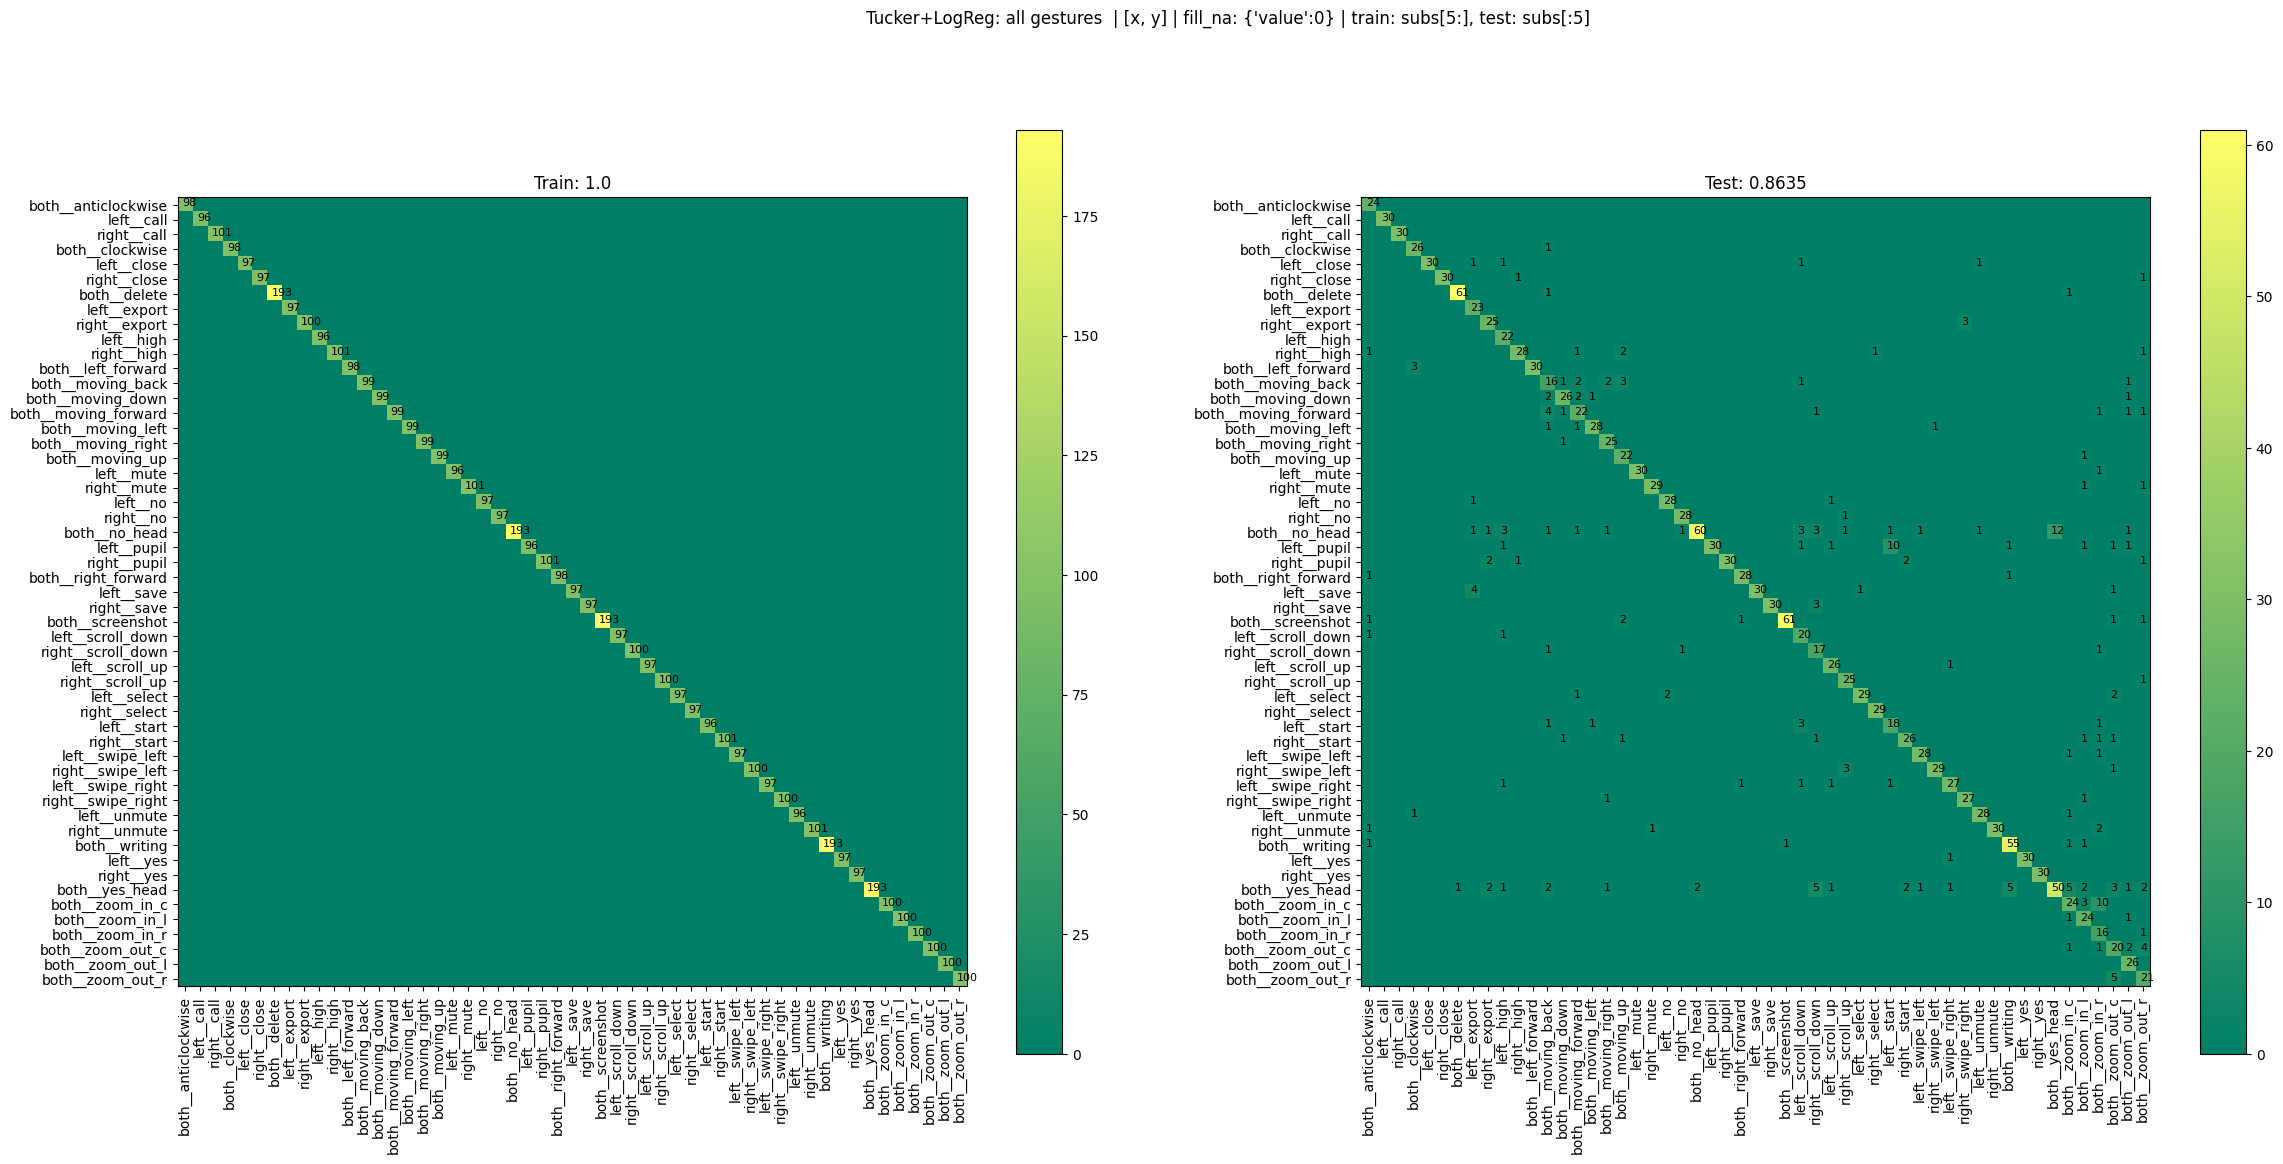

In [21]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle(model_name+ ": "+ exp_cofig)
print()

#### Random Forest

In [54]:
model = RandomForestClassifier(n_estimators=200)
model_name = 'Tucker + RF'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200)

2
2



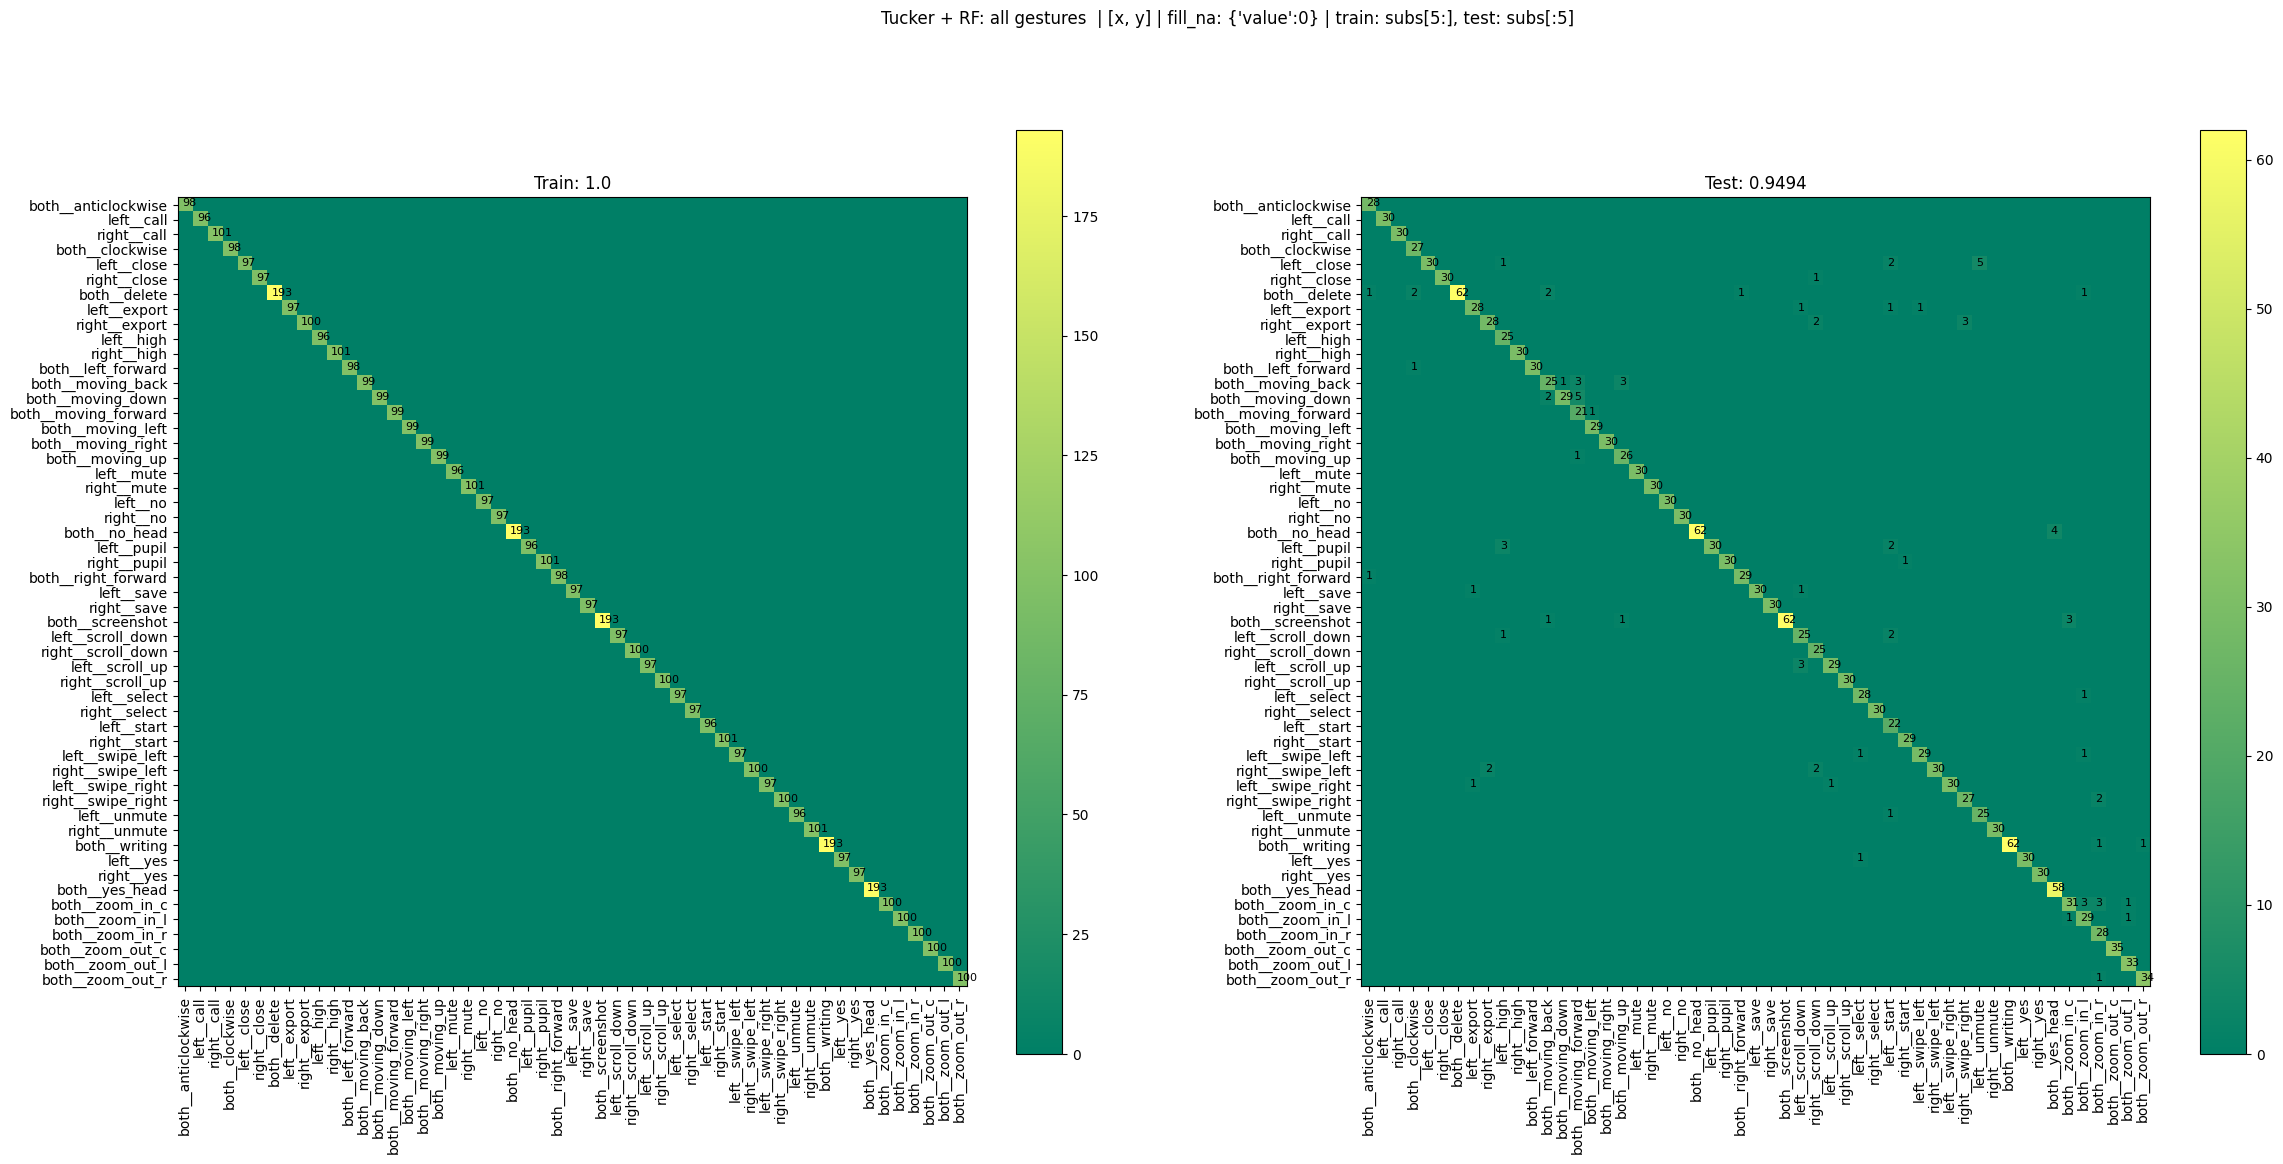

In [55]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### XGBoost

In [52]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=6)

model_name = 'Tucker + XGB'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



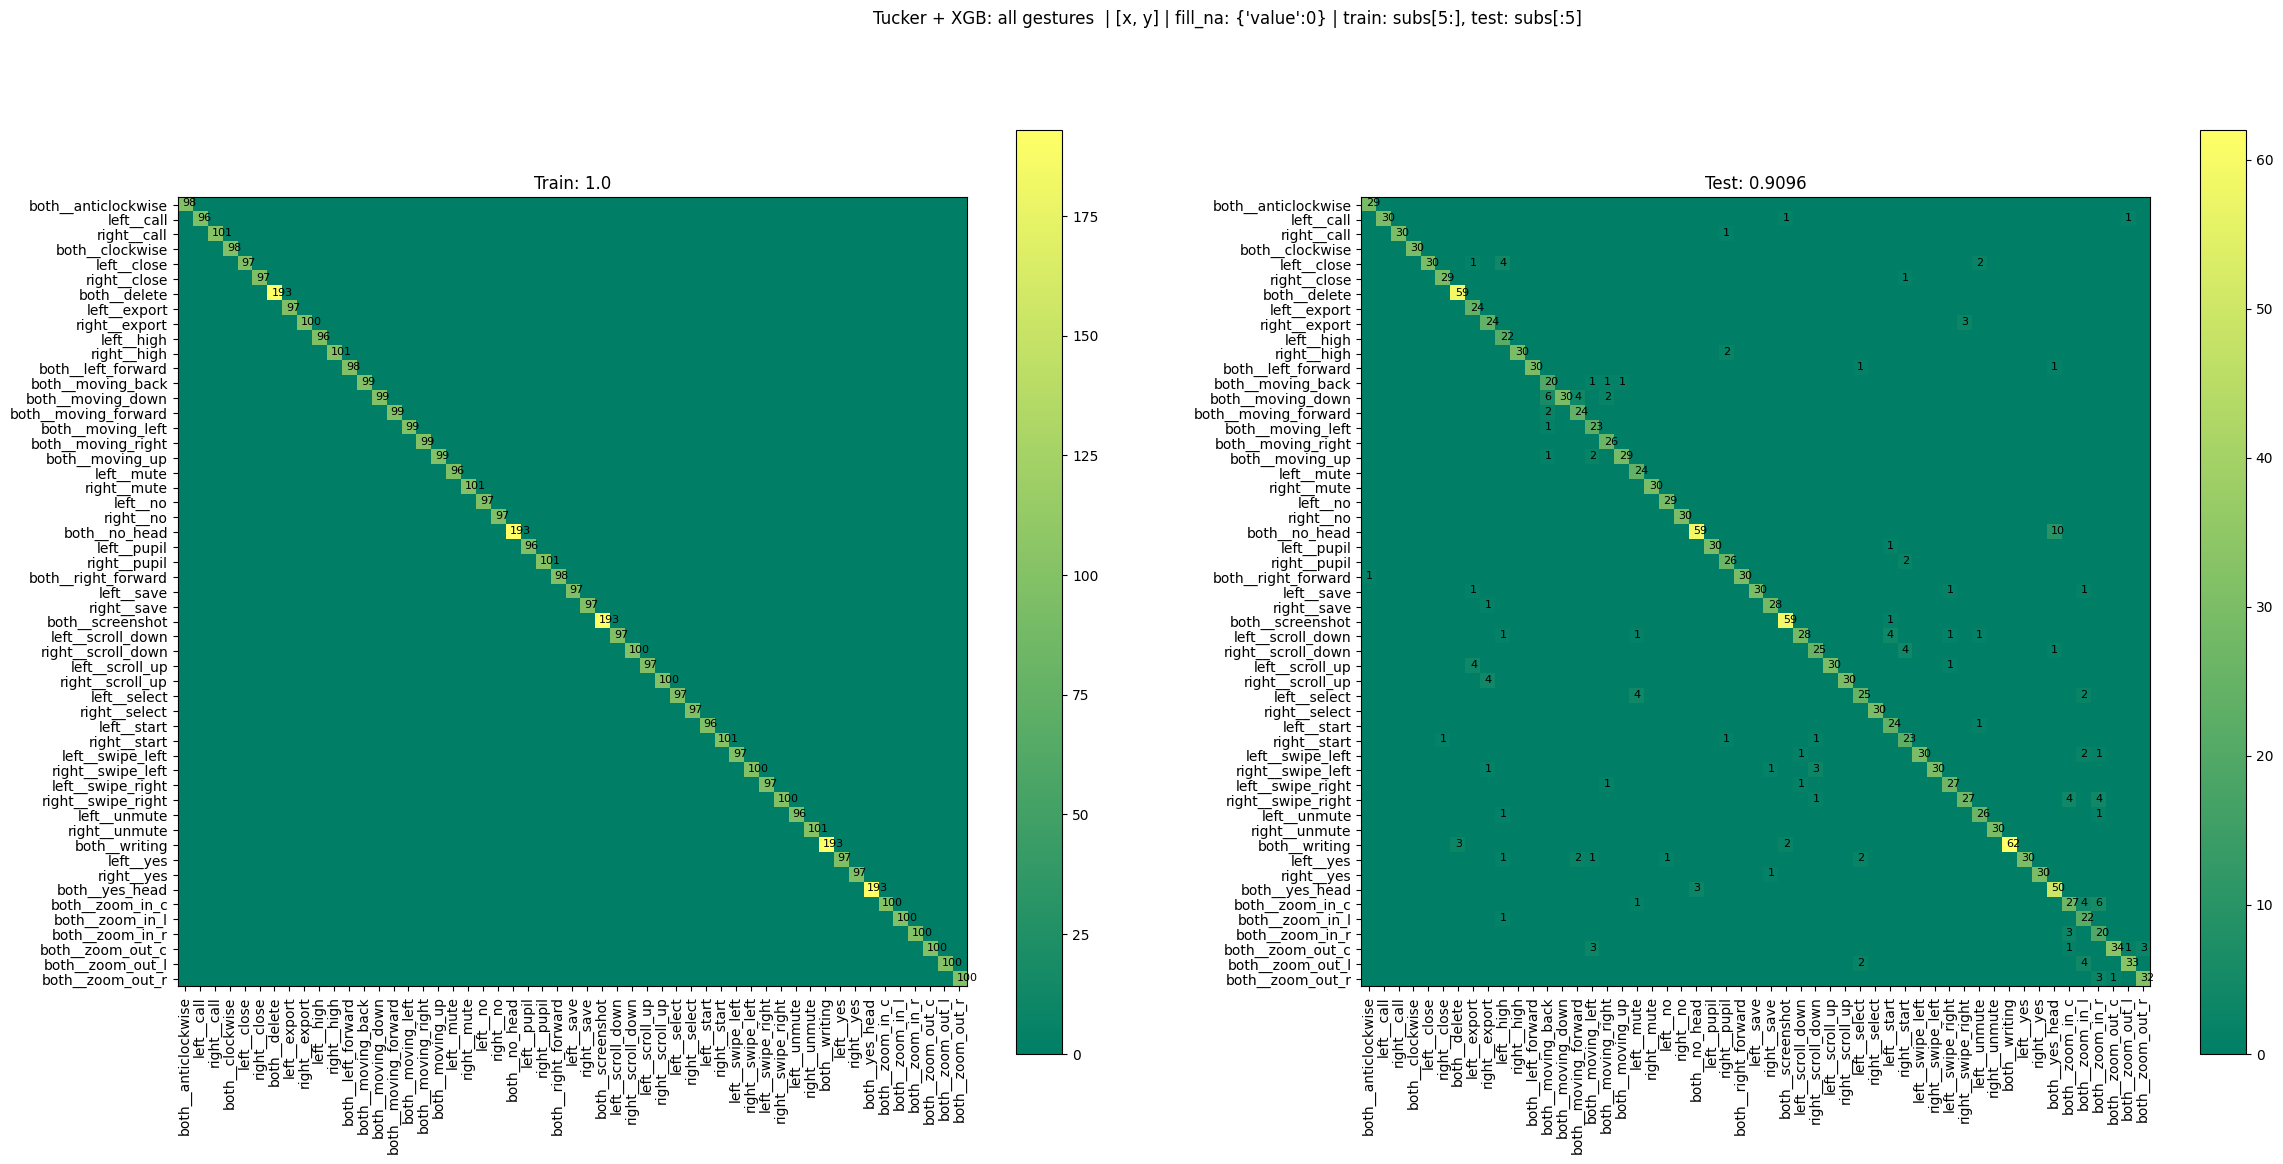

In [53]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### SVM

In [62]:
model = SVC(C=1, kernel='linear')
model_name = 'Tucker + SVC'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

2
2



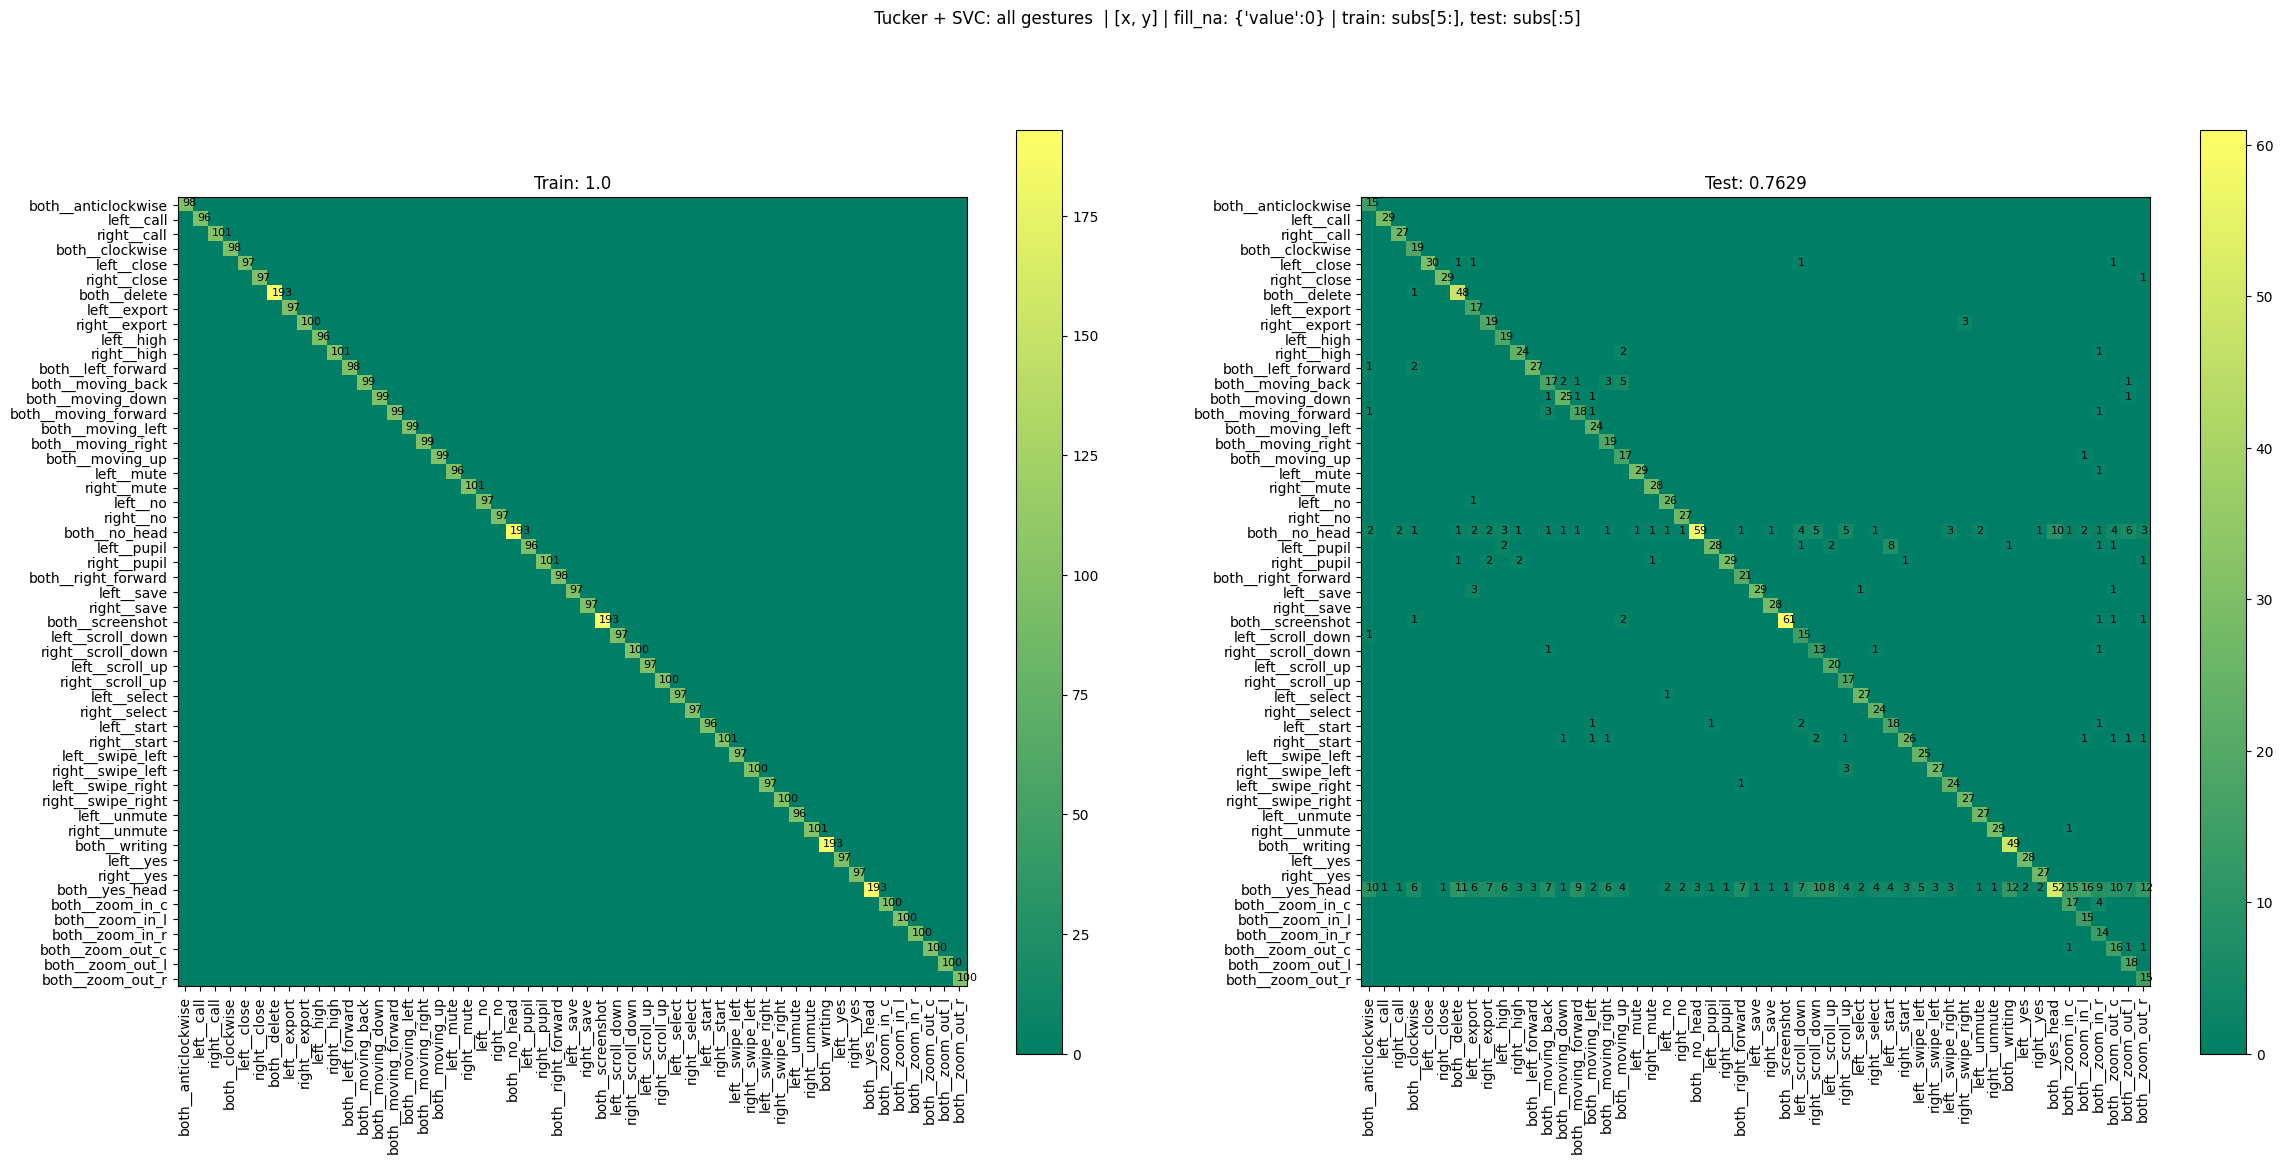

In [63]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### STM

In [68]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'Tucker + STMM'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = tensor_tucker
X_test = tensor_test

model.fit(X_train, y_train)


maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


STMM(maxIter=2, tol=0.01, tolSTM=0.01)

2
2



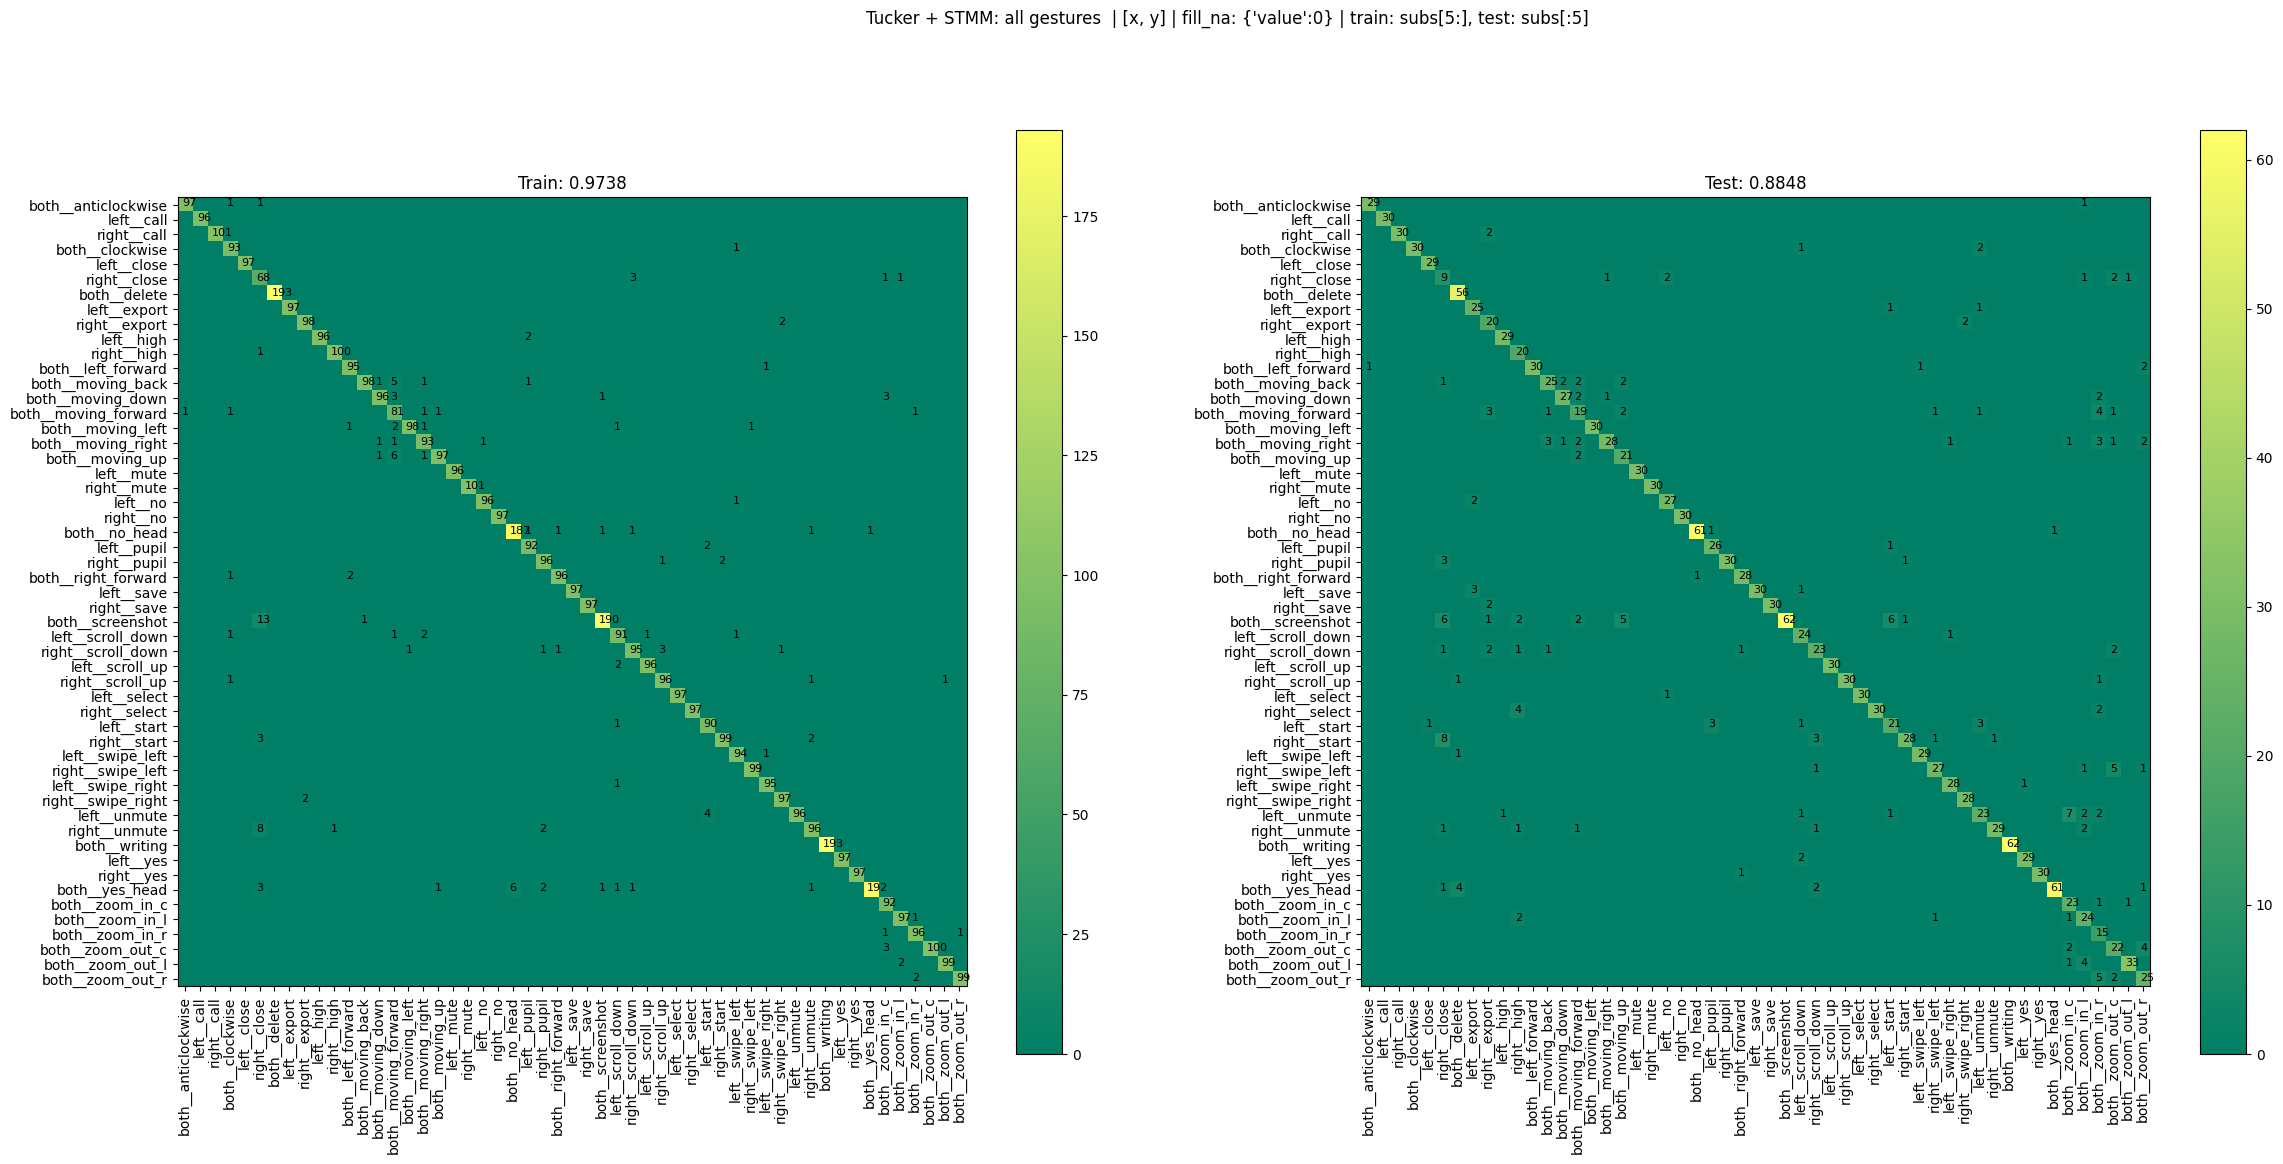

In [69]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name + ": "+ exp_cofig)
print()

#### KNN

In [60]:
model = KNeighborsClassifier(n_neighbors=30)
model_name = 'Tucker+ KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

2
2



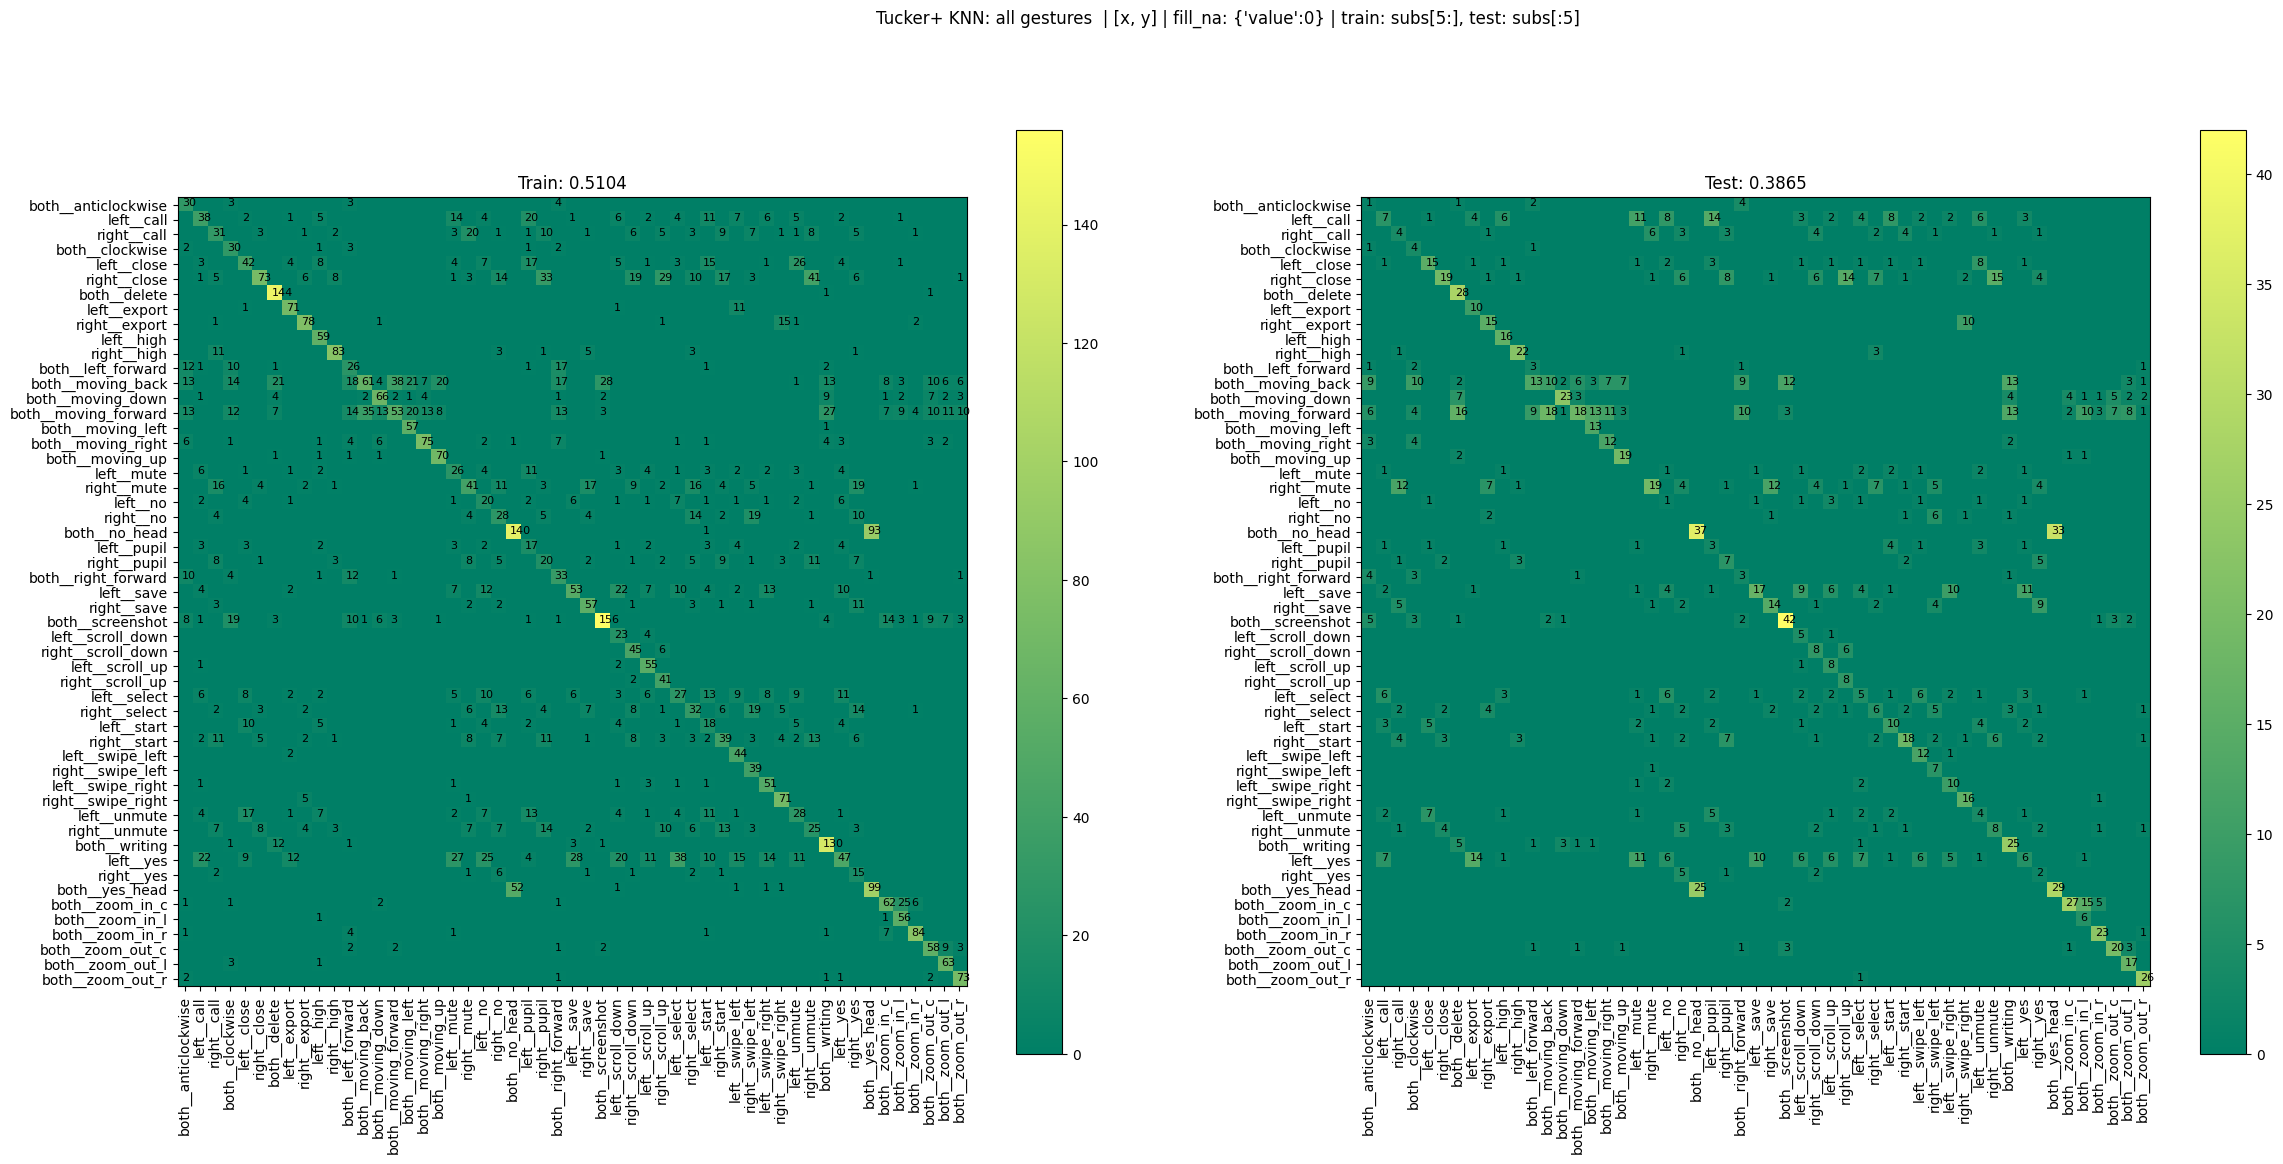

In [61]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

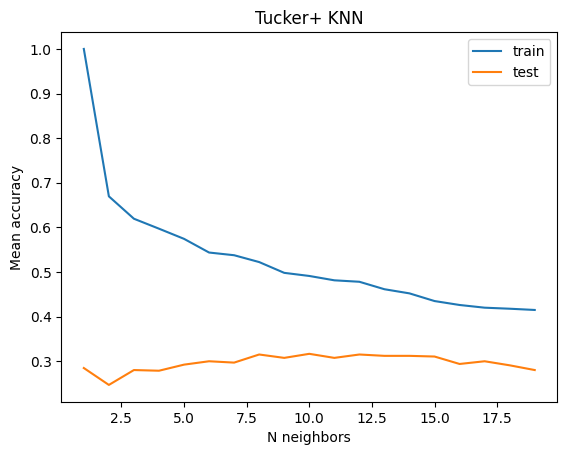

In [33]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  